In [1]:
import pandas as pd
import numpy as np
np.random.seed(20251023)

data = pd.read_json("https://raw.githubusercontent.com/krisrs1128/distortions-data/main/data/mammoth_3d.json")
data.columns = ["x", "y", "z"]

In [2]:
data

x        y        z
0     430.826  106.864   24.492
1     397.734   99.293   14.370
2     480.505   80.876  131.561
3     422.736   87.715   13.504
4     414.840  113.363   78.061
...       ...      ...      ...
9995  492.742 -114.477  107.954
9996  502.376  -94.579  117.065
9997  467.228 -168.295   97.806
9998  494.780 -111.272  115.444
9999  486.007 -150.081  114.390

[10000 rows x 3 columns]

In [3]:
from anndata import AnnData
import scanpy as sc

n_neighbors = 50
adata = AnnData(X=data, obs=pd.DataFrame(index=data.index))
sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.umap(adata)
embedding = adata.obsm["X_umap"].copy()

In [4]:
import numpy as np

radius = 3 * np.mean(adata.obsp["distances"].data)
parameters = {
    "radius": 2 ** (np.linspace(-1, 1, 10)) * radius,
    "scaling_epps": np.linspace(3, 7, 10)
}

In [5]:
radius

32.194828033447266

In [6]:
from distortions.geometry import Geometry
from distortions.geometry import expand_geoms
from distortions.geometry import metric_sensitivity

n_neighbors = 50
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": 5})
geoms, params_df = expand_geoms(geom, parameters)
Hvv, Hs = metric_sensitivity(geoms, embedding, data)

In [7]:
plot_data = []
for i in range(Hs.shape[1]):
    for j in range(Hs.shape[0]):
        plot_data.append({
            "sample": i,
            "combination": j,
            "hv00": float(Hvv[j, i, 0, 0]),
            "hv11": float(Hvv[j, i, 1, 1]),
            "hv01": float(Hvv[j, i, 0, 1]),
            "hv10": float(Hvv[j, i, 1, 0]),
            "hs0": float(Hs[j, i, 0]),
            "hs1": float(Hs[j, i, 1])
        })

params_df["combination"] = params_df.index
plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.merge(params_df)

This is variation in the coordinate $H_{00}$ across choices of radius and scaling epsilon.

In [8]:
import altair as alt
alt.data_transformers.enable("vegafusion")

random_samples = np.random.choice(plot_df["sample"].unique(), size=20, replace=False)

charts = []
for i in random_samples:
    random_subset = plot_df[plot_df["sample"] == i]
    chart_ = alt.Chart(random_subset).mark_rect().encode(
        x=alt.X('radius:N', title='Radius', axis=alt.Axis(format='.2f')),
        y=alt.Y('scaling_epps:N', title='Epsilon', axis=alt.Axis(format='.2f')),
        fill=alt.Fill('hv00:Q', title='h')
    )
    charts.append(chart_)

#[display(p) for p in charts]

Here is change in the singular values across the same parameters.

In [9]:
charts = []
for i in random_samples:
    random_subset = plot_df[plot_df["sample"] == i]
    chart_ = alt.Chart(random_subset).mark_rect().encode(
        x=alt.X('radius:N', title='Radius', axis=alt.Axis(format='.2f')),
        y=alt.Y('scaling_epps:N', title='Epsilon', axis=alt.Axis(format='.2f')),
        fill=alt.Fill('hs0:Q', title='h')
    )
    charts.append(chart_)

#[display(p) for p in charts]

Here are some line plots to visualize sensitivity across **all** samples.

In [10]:
import altair as alt
alt.data_transformers.enable("vegafusion")

ixl = np.random.choice(plot_df["sample"].unique(), size=500, replace=False)
sub_df = plot_df.loc[plot_df["sample"].isin(ixl)]

line_plots = []
p = alt.Chart(sub_df).mark_line(size=0.2).encode(
    x=alt.X('scaling_epps:Q', title='Rescaling Epsilon'),
    y=alt.Y('hv00:Q', title='Hvv[0,0]'),
    detail=['sample:N', 'radius:Q']
)
line_plots.append(p)

p = alt.Chart(sub_df).mark_line(size=0.2).encode(
    x=alt.X('radius:Q', title='Radius'),
    y=alt.Y('hv00:Q', title='Hvv[0,0]'),
    detail=['sample:N', 'scaling_epps:Q']
)
line_plots.append(p)

p = alt.Chart(sub_df).mark_line(size=0.2).encode(
    x=alt.X('scaling_epps:Q', title='Rescaling Epsilon'),
    y=alt.Y('hs0:Q', title='first singular value'),
    color=alt.Color('radius:Q'),
    detail=['sample:N', "radius:Q"]
)
line_plots.append(p)

p = alt.Chart(sub_df).mark_line(size=0.2).encode(
    x=alt.X('radius:Q', title='Laplacian Radius'),
    y=alt.Y('hs0:Q', title='first singular value'),
    color=alt.Color('scaling_epps:Q'),
    detail=['sample:N', "scaling_epps:Q"]
)
line_plots.append(p)

#[display(p) for p in line_plots]

In [11]:
p = alt.Chart(sub_df).mark_line(size=0.2, clip=True).encode(
    x=alt.X('scaling_epps:Q', title='Rescaling Epsilon'),
    y=alt.Y('hs0:Q', title='first singular value', scale=alt.Scale(domain=[0, 0.5])),
    color=alt.Color('radius:Q'),
    detail=['sample:N', 'radius:Q']
)
line_plots.append(p)

p = alt.Chart(sub_df).mark_line(size=0.2, clip=True).encode(
    x=alt.X('radius:Q', title='Laplacian Radius'),
    y=alt.Y('hs0:Q', title='first singular value', scale=alt.Scale(domain=[0, 0.5])),
    color=alt.Color('scaling_epps:Q'),
    detail=['sample:N', 'scaling_epps:Q']
)
line_plots.append(p)

#[display(p) for p in line_plots[-2:]]

In [12]:
p = alt.Chart(sub_df).mark_line(size=0.2).encode(
    x=alt.X('scaling_epps:Q', title='Rescaling Epsilon'),
    y=alt.Y('hs0:Q', title='first singular value', scale=alt.Scale(type='log')),
    color=alt.Color('radius:Q'),
    detail=['sample:N', 'radius:Q']
)
line_plots.append(p)

p = alt.Chart(sub_df).mark_line(size=0.2).encode(
    x=alt.X('radius:Q', title='Laplacian Radius'),
    y=alt.Y('hs0:Q', title='first singular value', scale=alt.Scale(type='log')),
    color=alt.Color('scaling_epps:Q'),
    detail=['sample:N', 'scaling_epps:Q']
)
line_plots.append(p)

#[display(p) for p in line_plots[-2:]]

In [13]:
sub_df.to_csv("data/sensitivity_sub_df.csv")

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl

def ellipse_sequence(single_sample):
    Hvv_i, Hs_i = [], []
    for i in range(len(single_sample)):
        h = np.array([
            [single_sample["hv00"].values[i],
            single_sample["hv01"].values[i]],
            [single_sample["hv10"].values[i],
            single_sample["hv11"].values[i]]
        ])
        s = np.array([
            single_sample["hs0"].values[i],
            single_sample["hs1"].values[i]
        ])

        Hvv_i.append(h)
        Hs_i.append(s)
    return Hvv_i, Hs_i

def plot_ellipses(Hvv_i, Hs_i, sample_df, max_cols=5, cmap_name='cividis'):
    """
    Facet by unique scaling_epps values and color ellipses by radius.

    Hvv_i and Hs_i must align with rows of sample_df.
    """
    epsilons = np.unique(sample_df["scaling_epps"].values)
    n_e = len(epsilons)
    ncols = min(max_cols, n_e)
    nrows = int(np.ceil(n_e / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(4 * ncols, 4 * nrows),
                             squeeze=False, constrained_layout=True)
    axes_flat = axes.ravel()

    # Colormap normalized over radius in this sample_df
    vmin = float(sample_df["radius"].min())
    vmax = float(sample_df["radius"].max())
    # Use a raw palette sequence
    palette = [
        "#7E1700", "#862D06", "#8F3F0D", "#984E14", "#9F5D1A", "#A56B1F", "#AC7926",
        "#B4872F", "#BB9739", "#C3A848", "#CAB95C", "#CFCB74", "#D1D98E", "#CFE4A6",
        "#C6E9BA", "#B9EAC8", "#A6E6D1", "#91DED6", "#7AD3D6", "#63C5D4", "#51B7D0",
        "#41A7CA", "#3698C4", "#2E8BBE", "#287DB8", "#246FB3", "#1F60AD", "#1952A6",
        "#11419F", "#023198"
    ]
    cmap = mpl.colors.ListedColormap(palette)

    # Map each epsilon value to an axis (use enumeration order)
    theta = np.linspace(0, 2 * np.pi, 200)
    epsilon_to_ax = {e: axes_flat[i] for i, e in enumerate(epsilons)}

    for idx, (vals, vecs) in enumerate(zip(Hs_i, Hvv_i)):
        circle = np.array([np.cos(theta), np.sin(theta)])
        ellipse = vecs @ np.diag(np.sqrt(np.abs(vals))) @ circle
        epsilon_val = sample_df["scaling_epps"].values[idx]
        radius_val = float(sample_df["radius"].values[idx])
        # Normalize radius to [0, 1] for colormap
        norm_radius = (radius_val - vmin) / (vmax - vmin) if vmax > vmin else 0.0
        color = cmap(norm_radius)
        ax = epsilon_to_ax[epsilon_val]
        ax.plot(ellipse[0, :], ellipse[1, :], lw=1, color=color, alpha=0.9)
        ax.set_title(f"epsilon={epsilon_val:.3g}")
        ax.set_aspect('equal')

    # Hide any unused axes
    for j in range(len(epsilons), len(axes_flat)):
        axes_flat[j].axis('off')

    # Add a colorbar for radius
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Required for colorbar

    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(),
                        orientation='horizontal', fraction=0.02, pad=0.04)
    cbar.set_label('radius')
    plt.show()

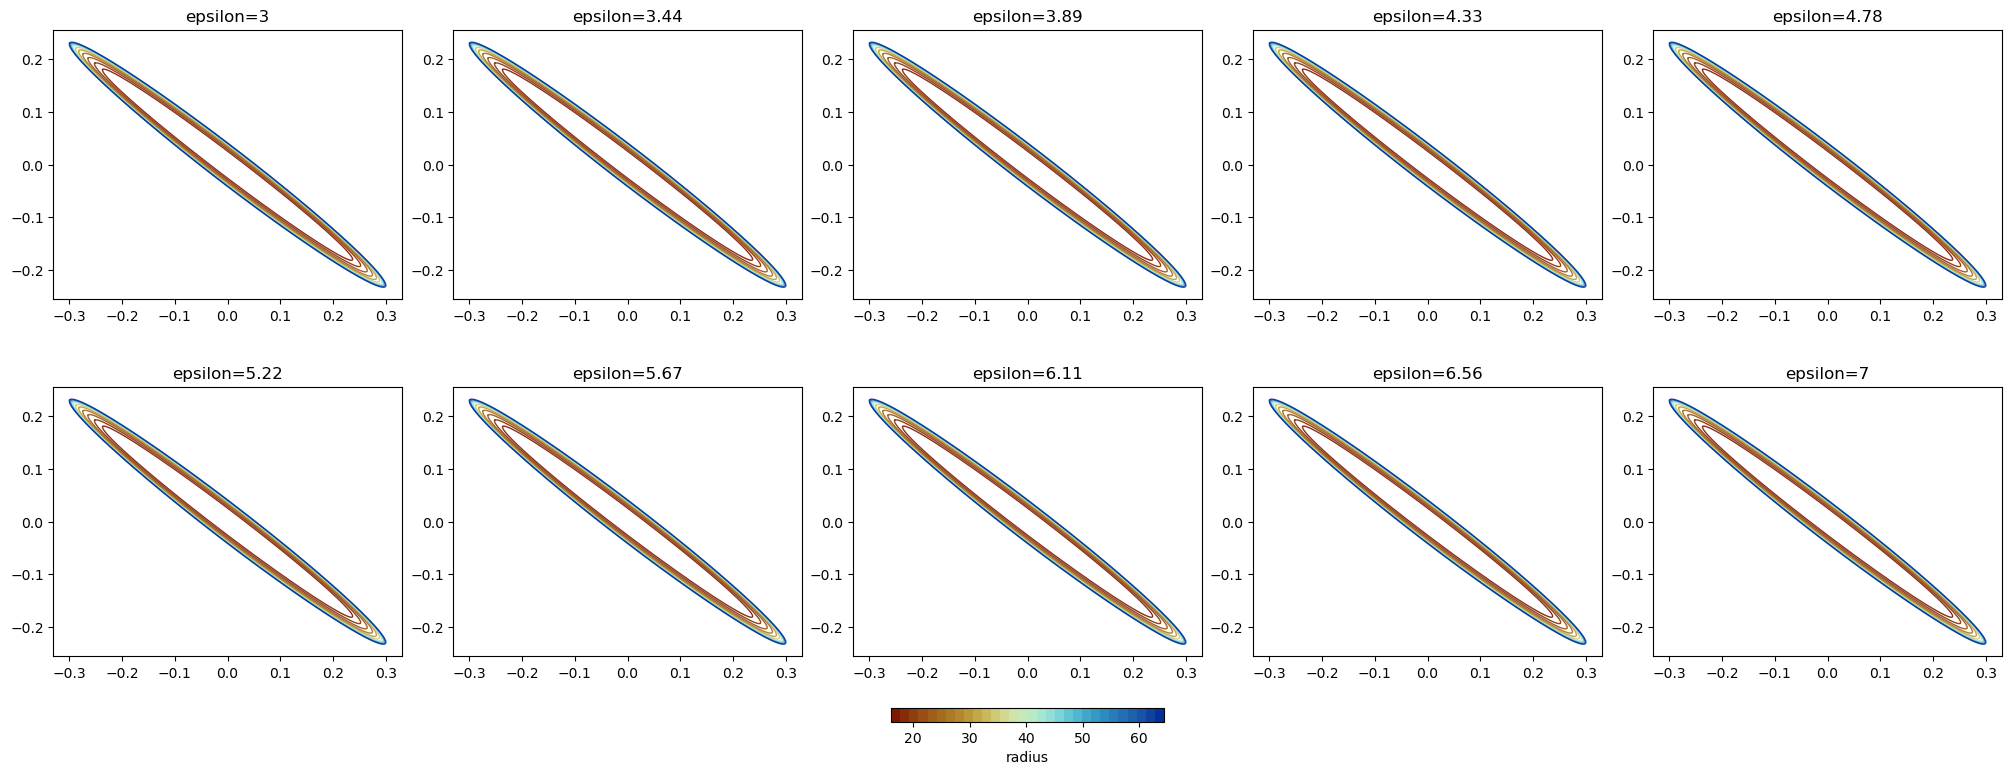

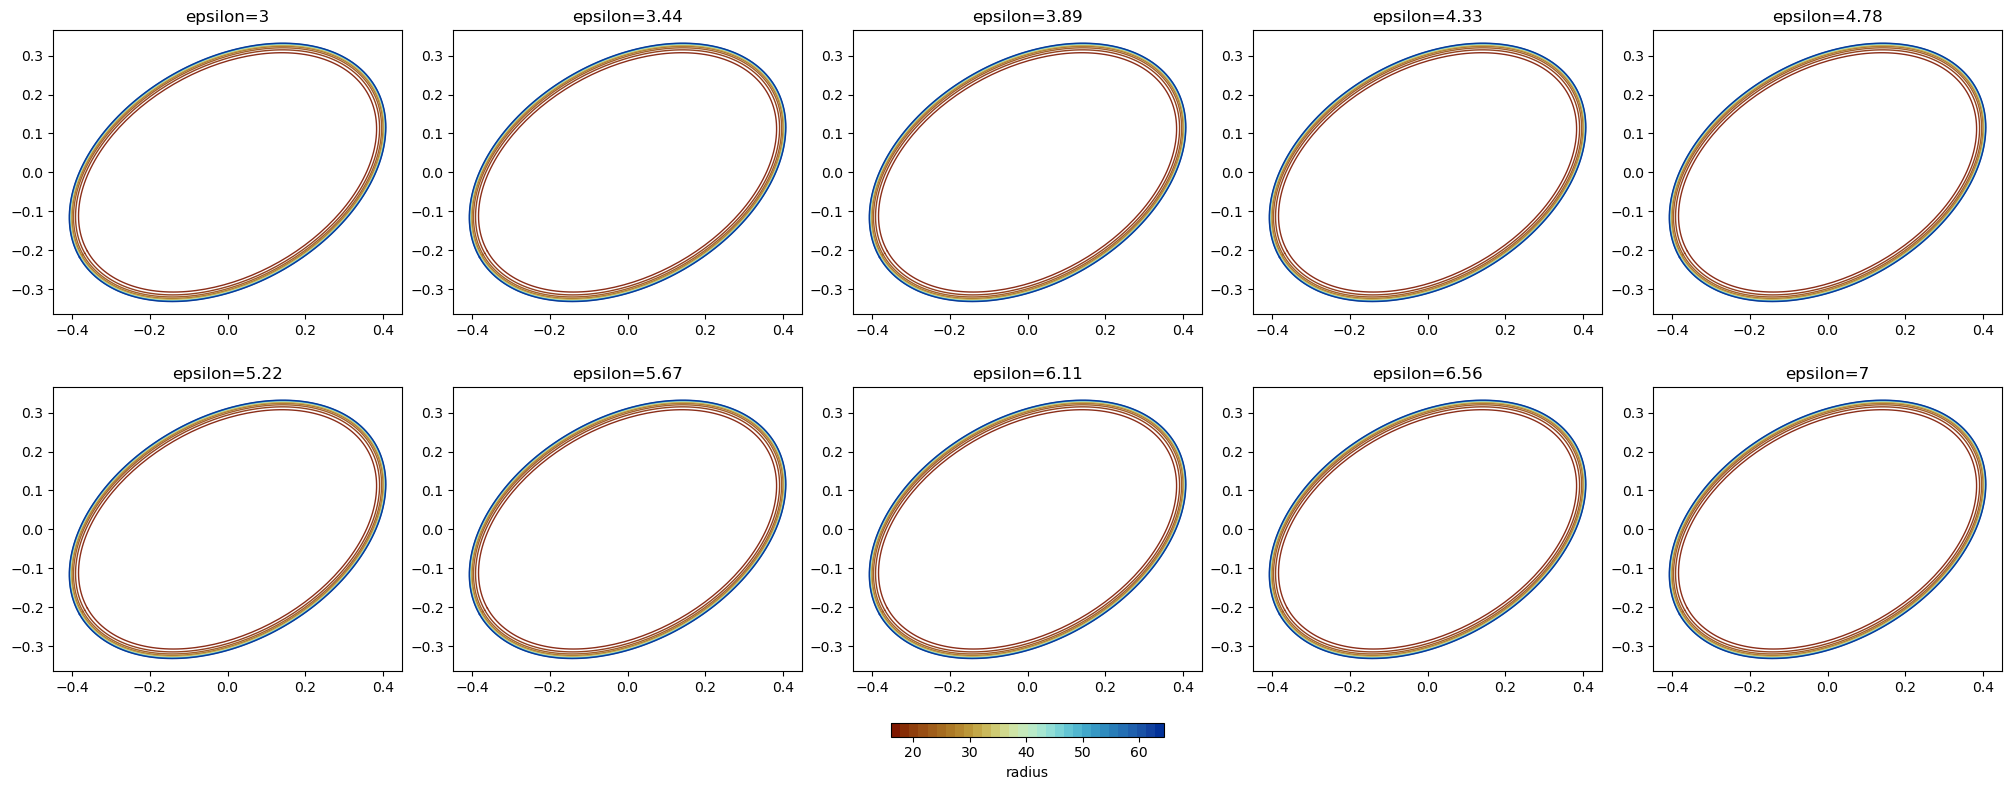

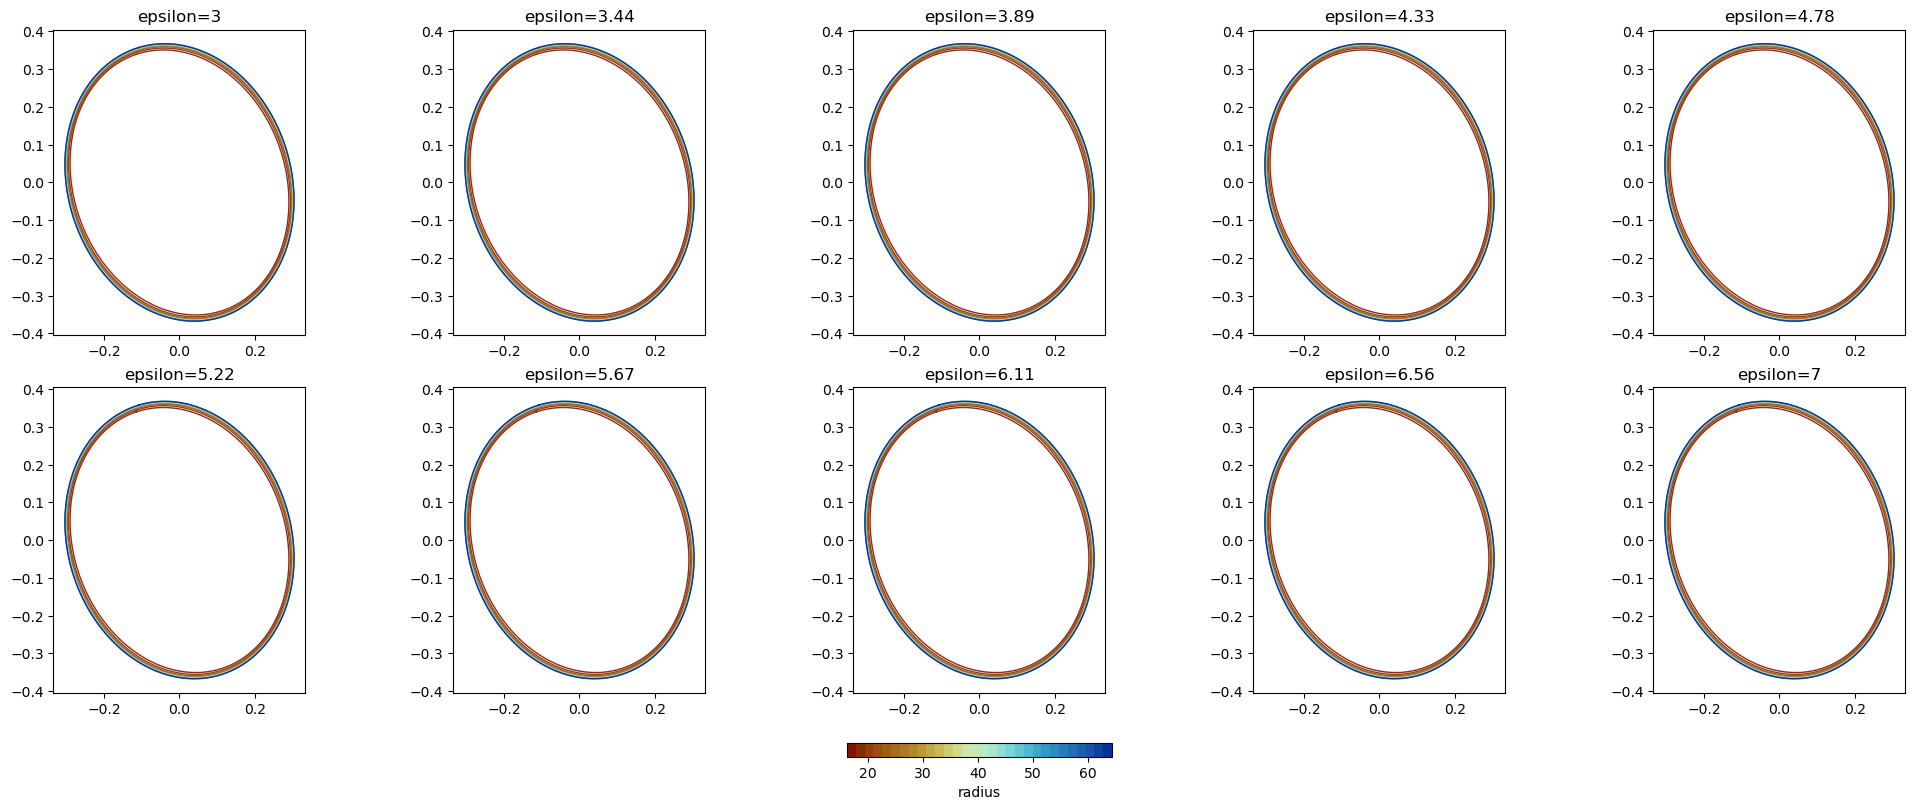

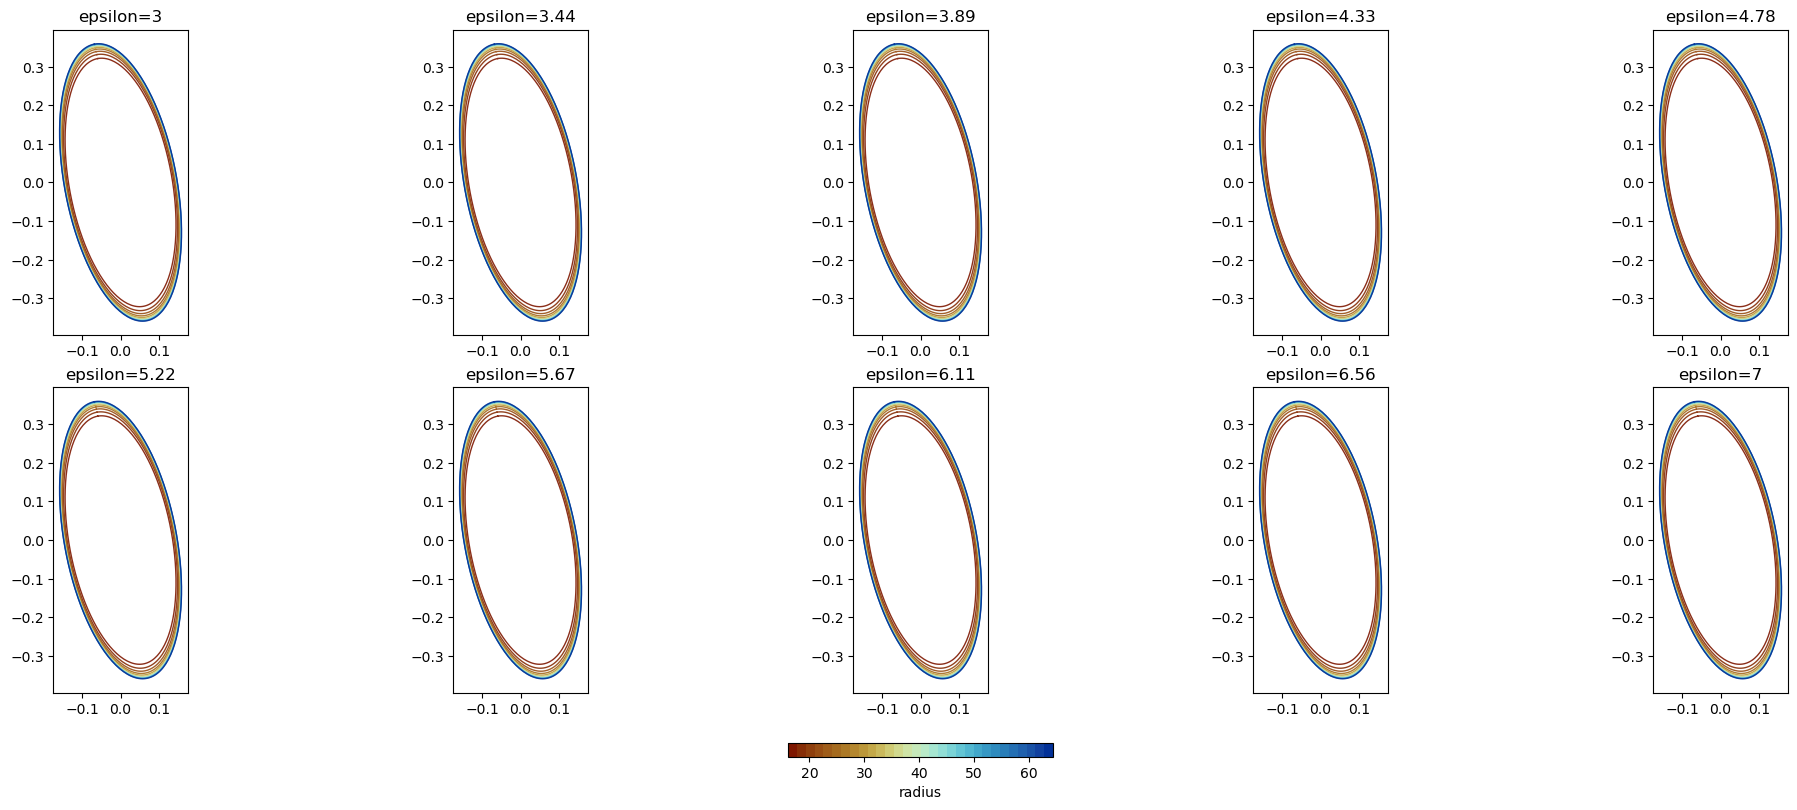

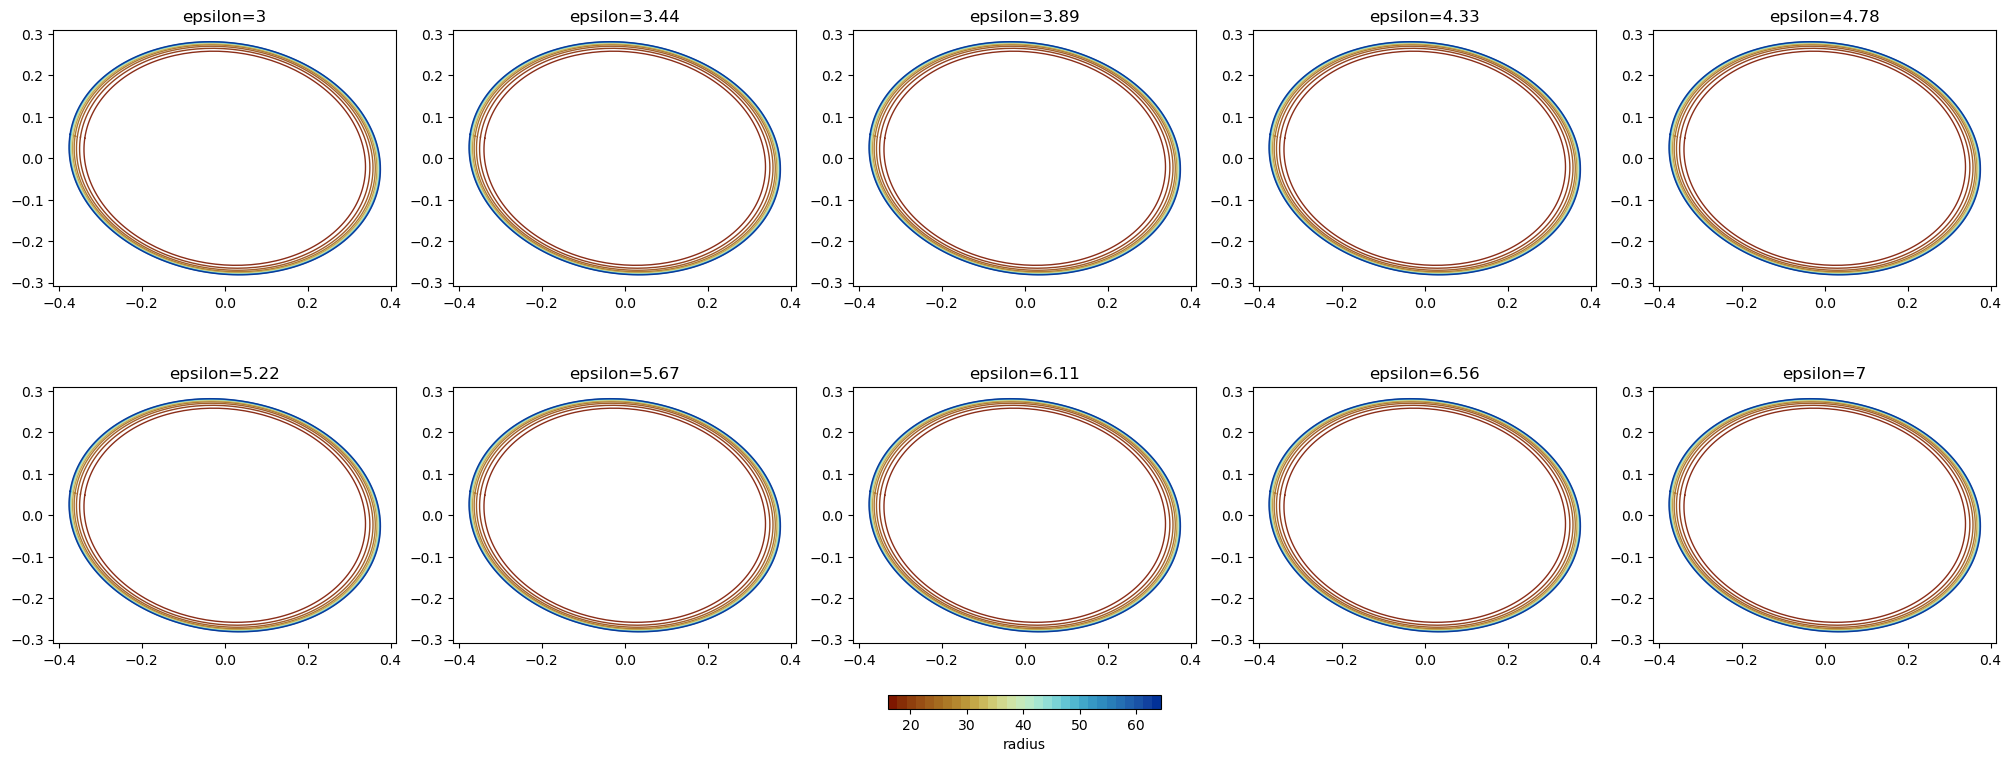

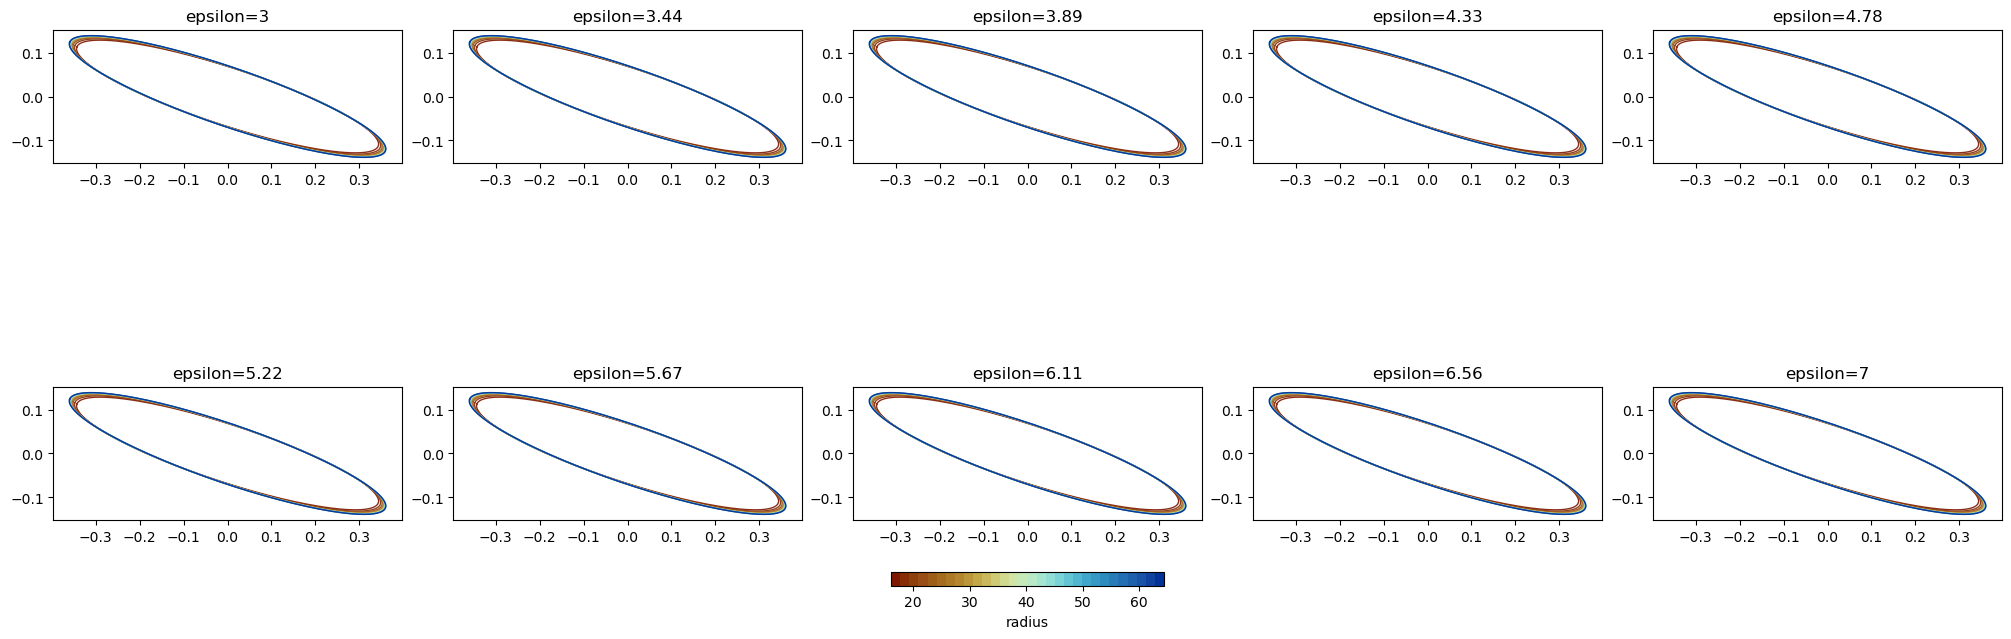

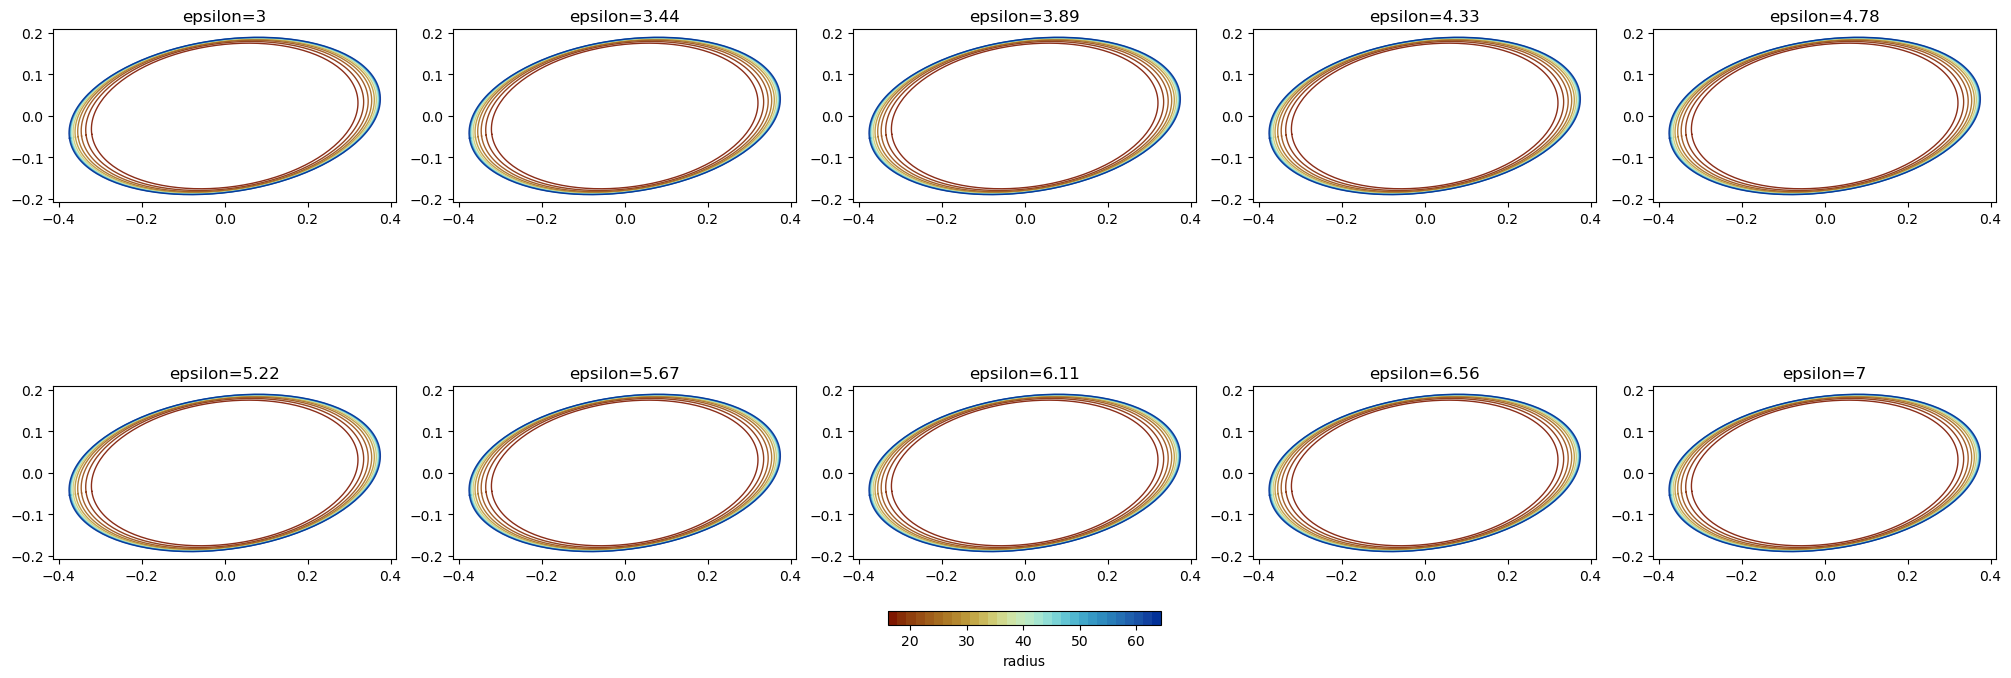

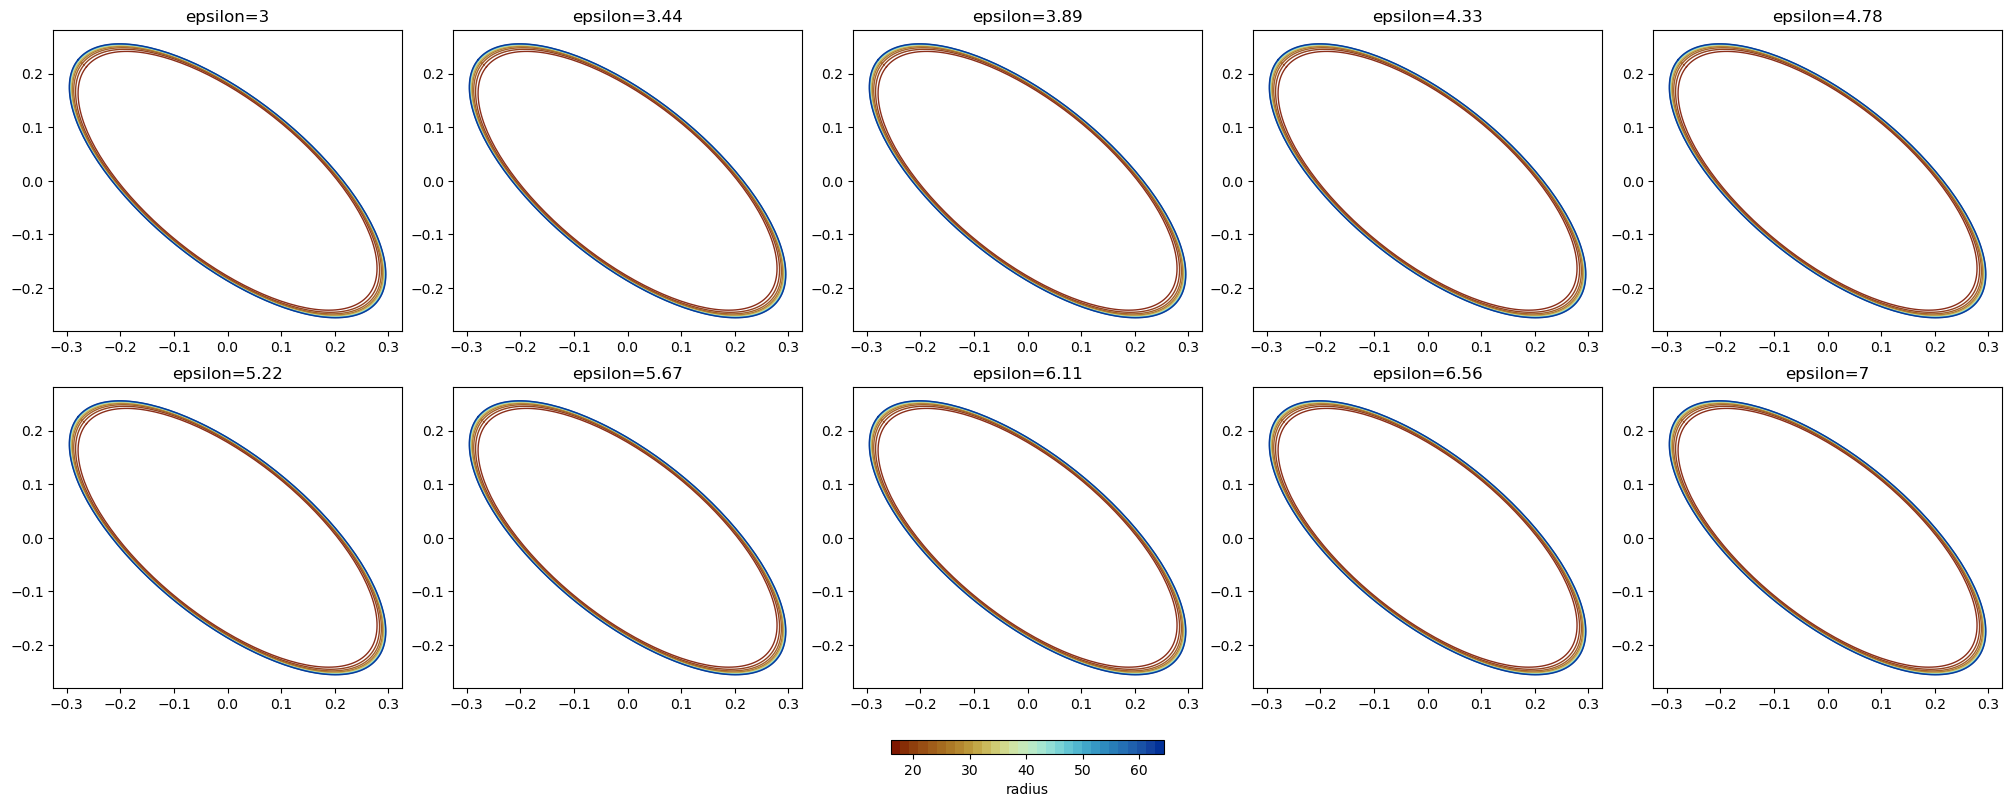

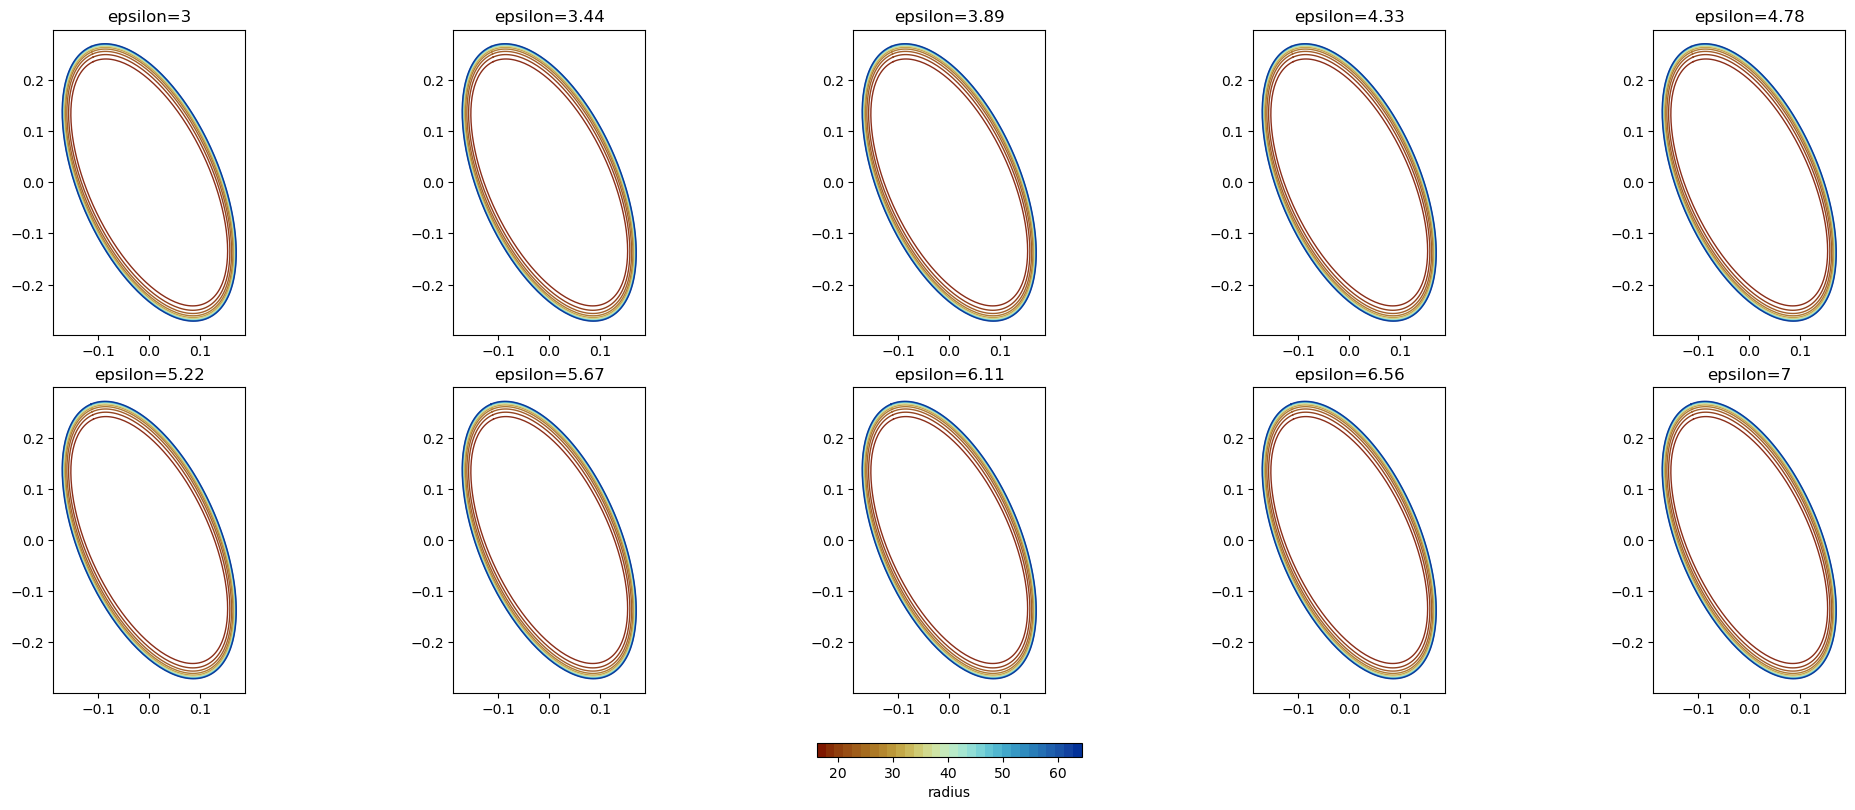

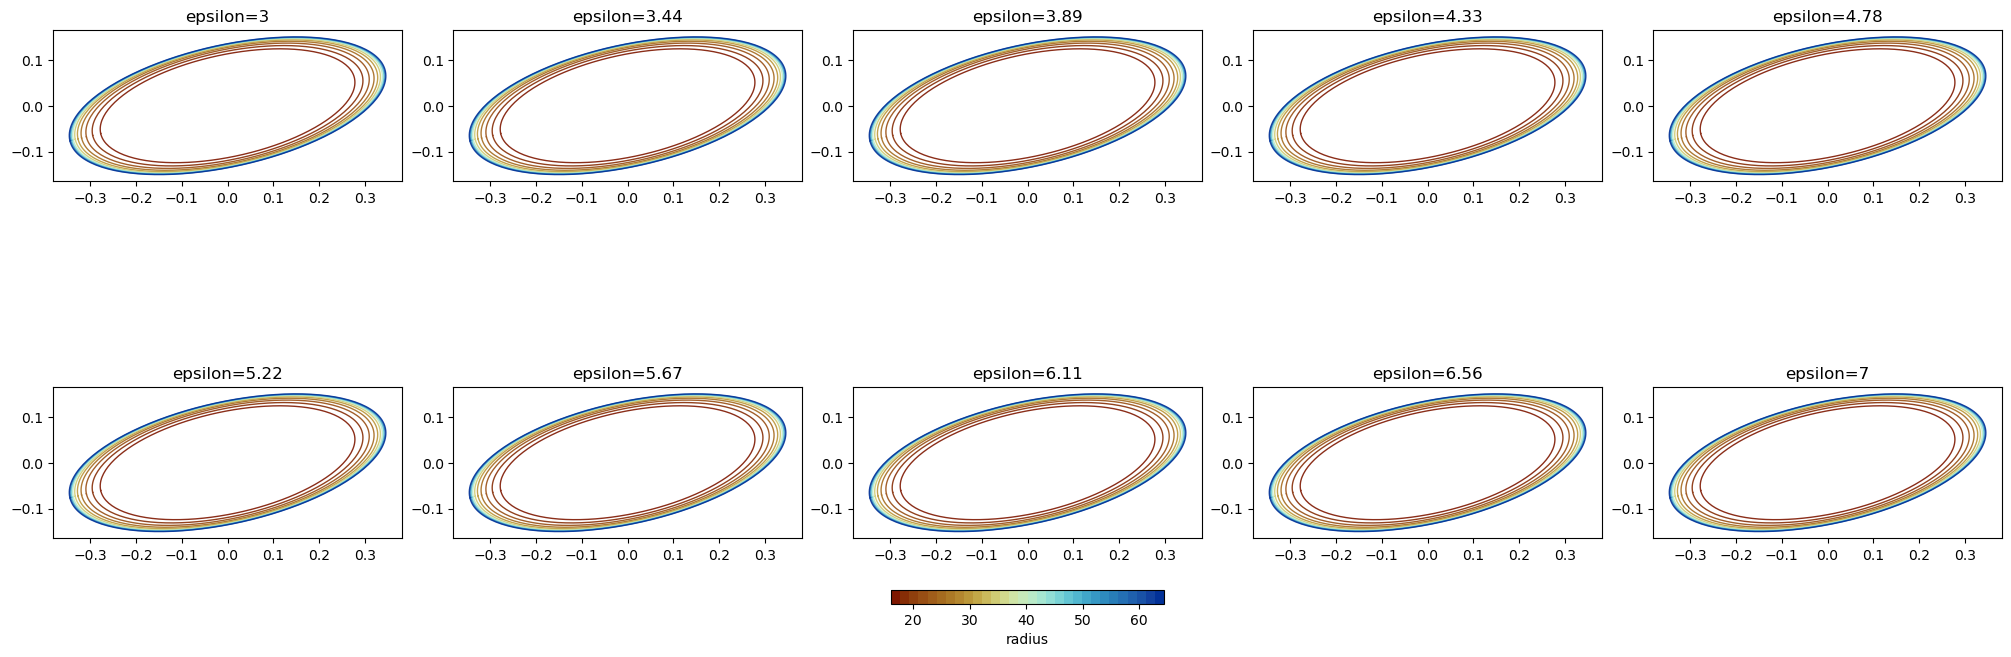

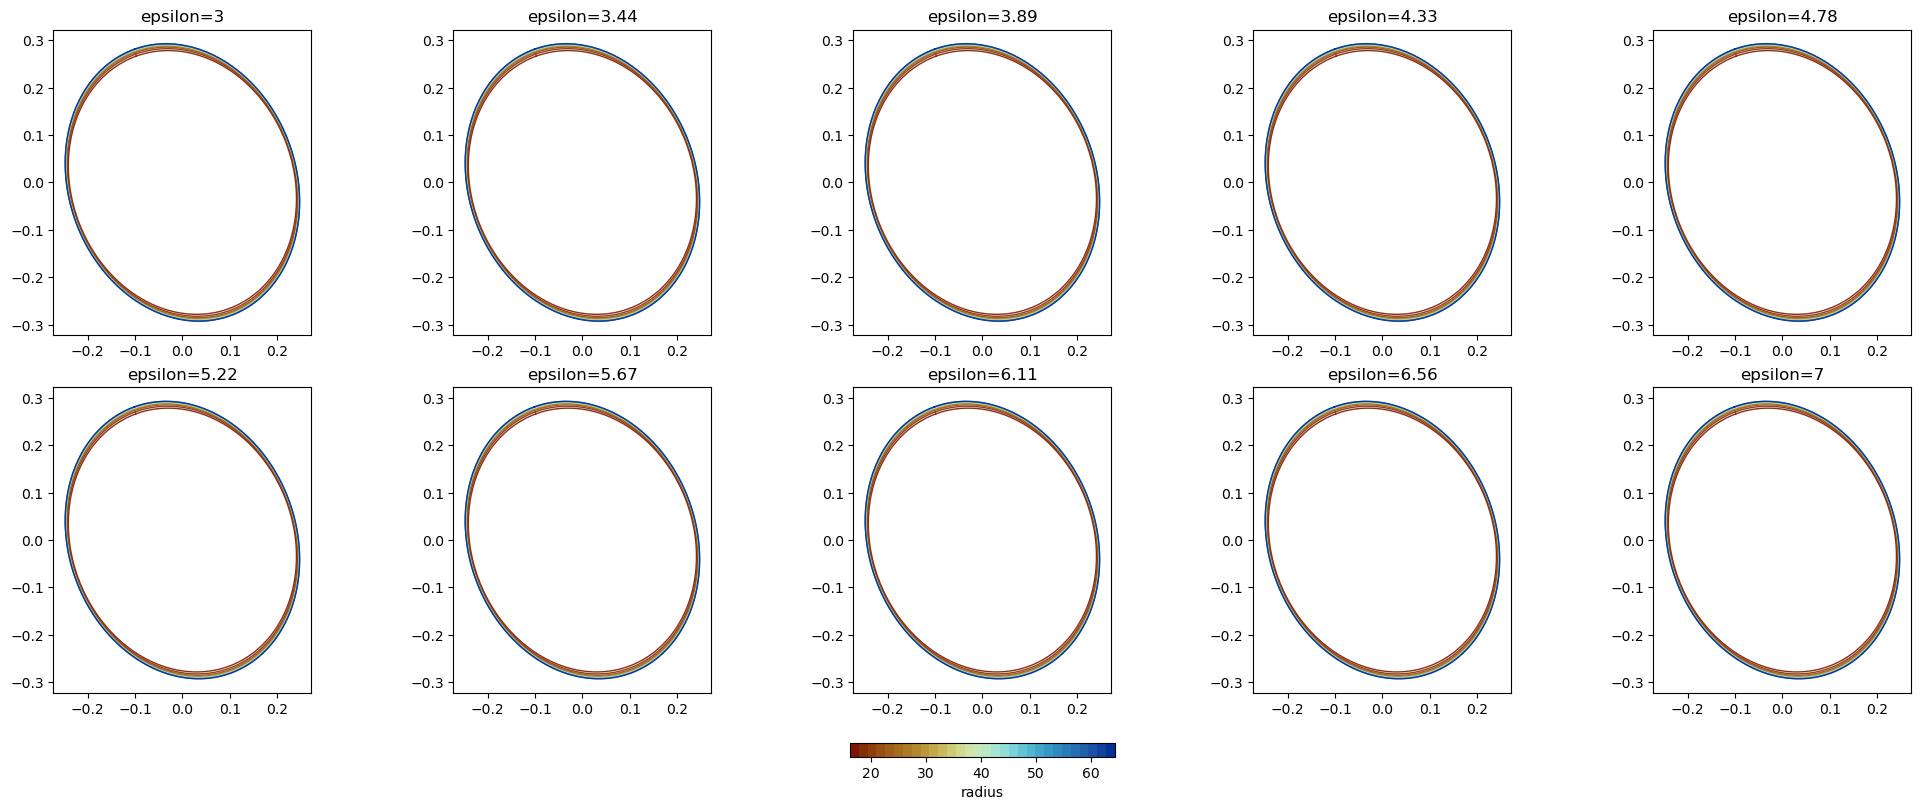

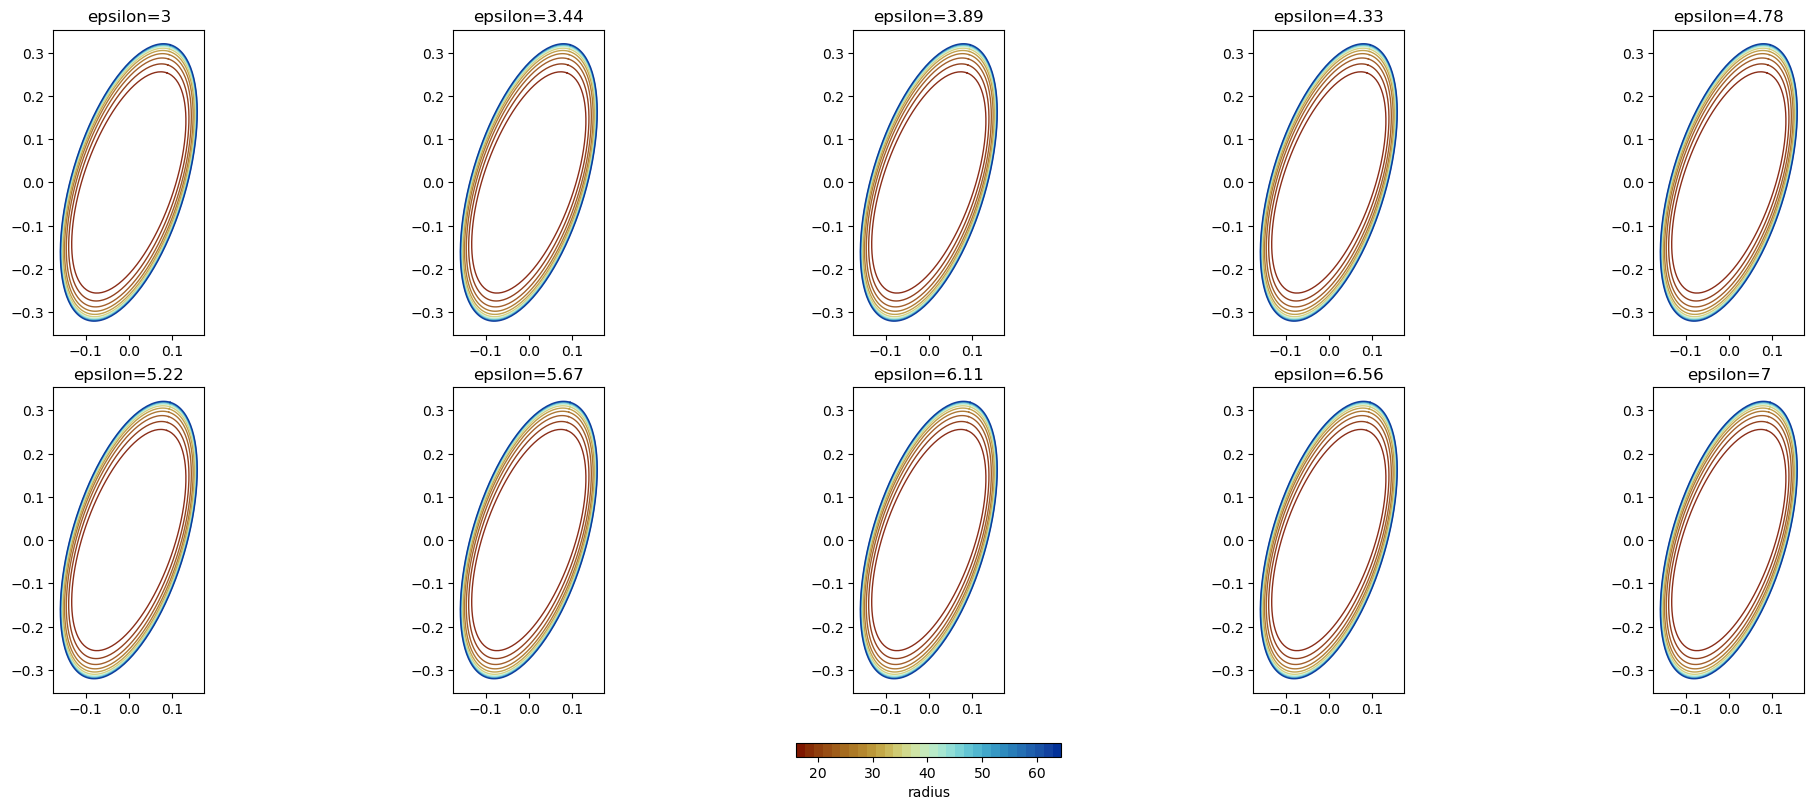

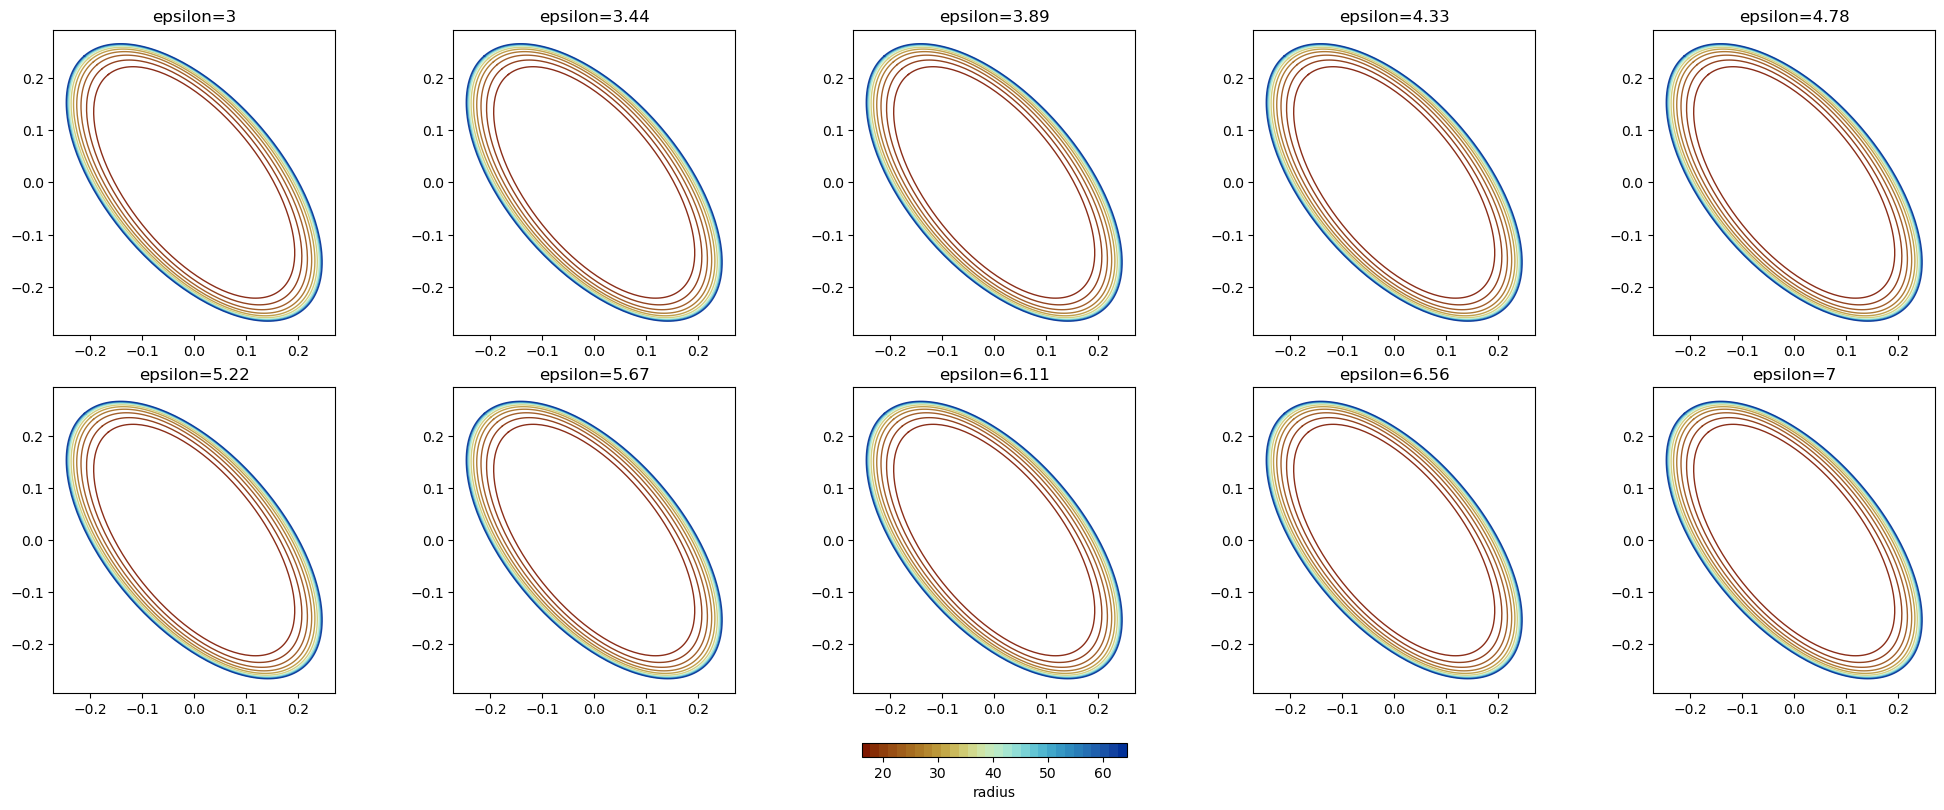

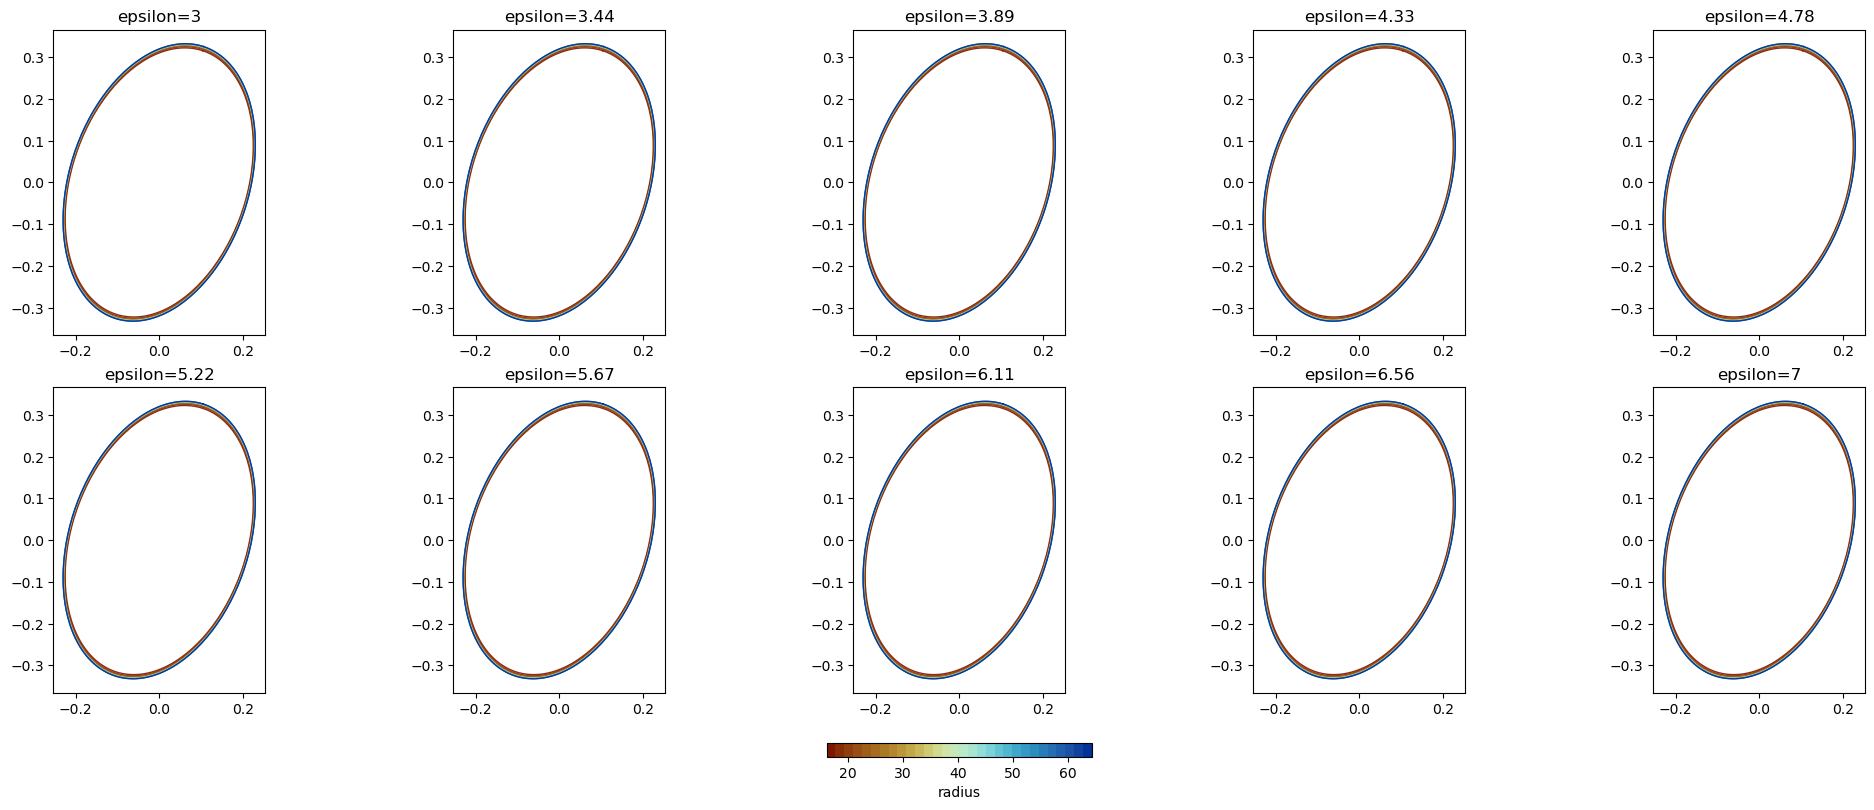

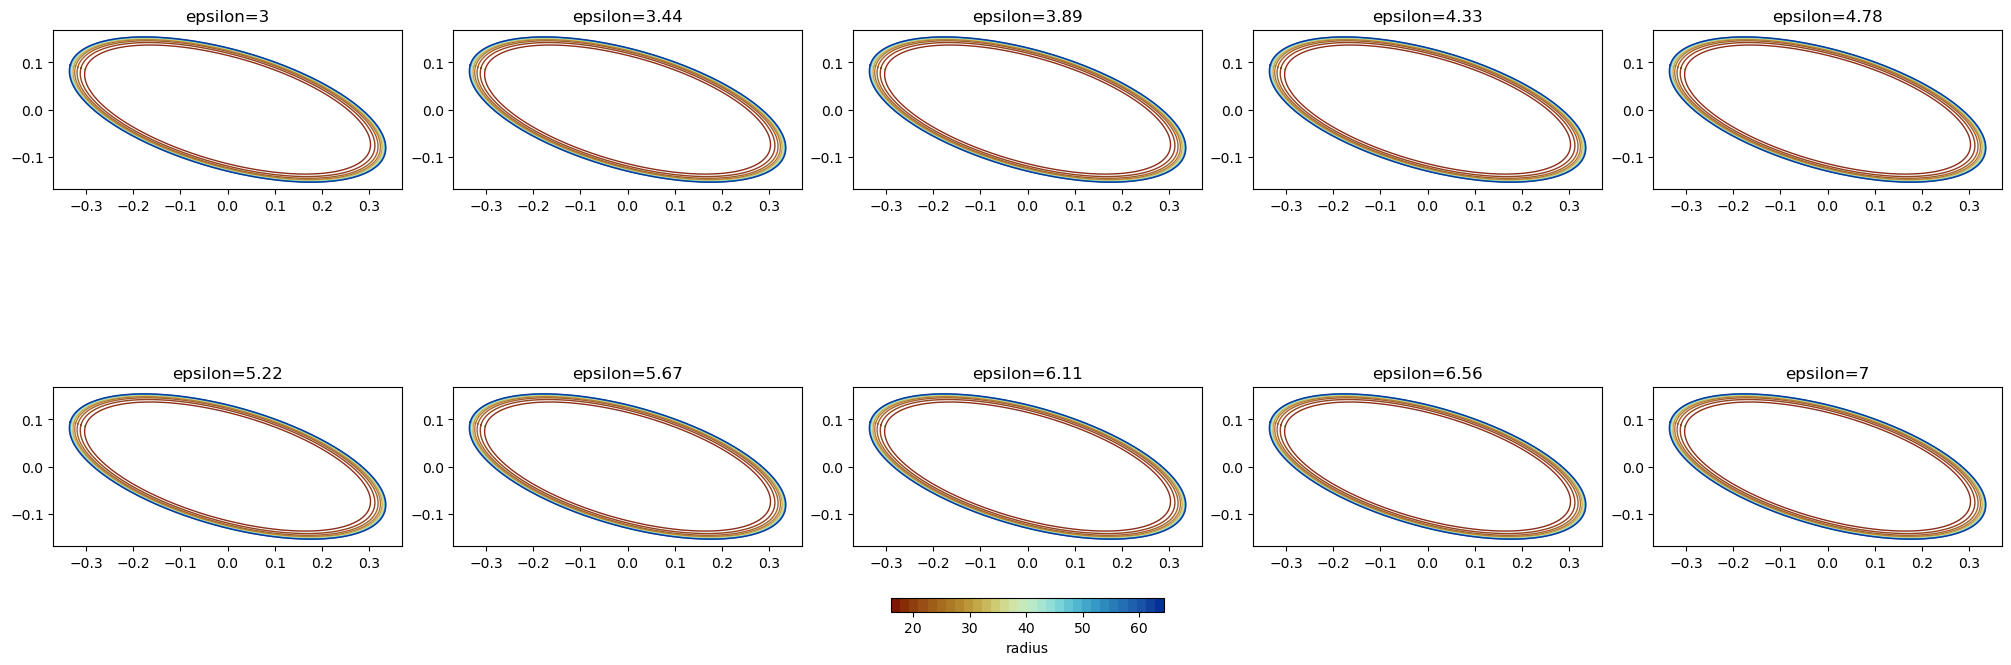

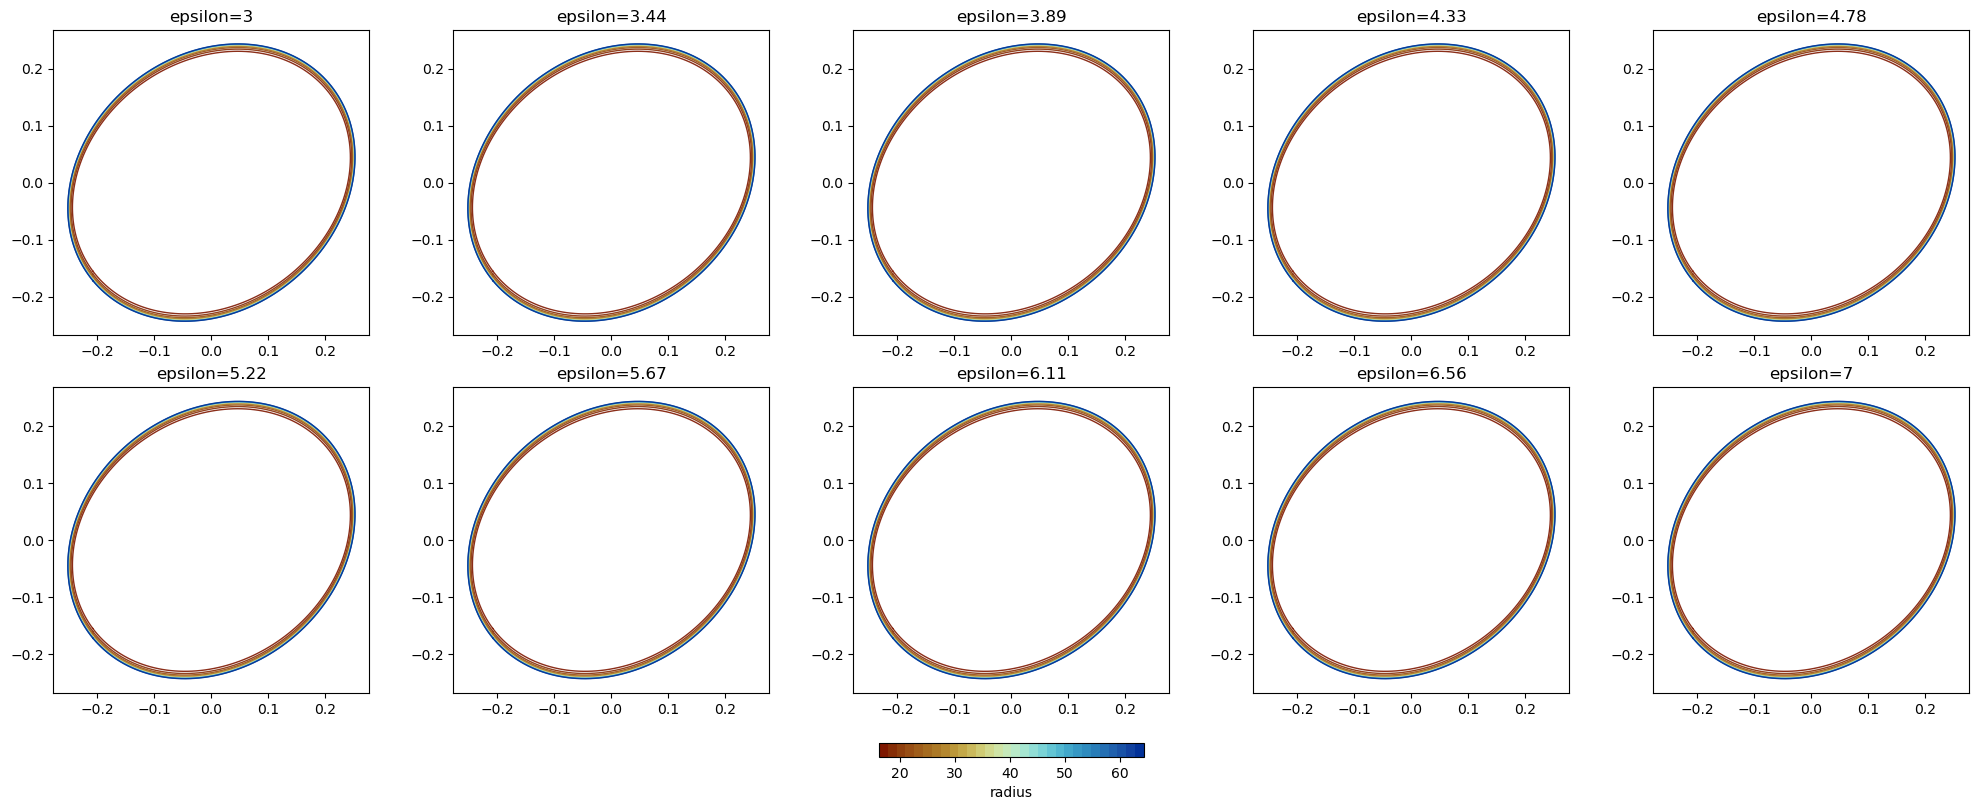

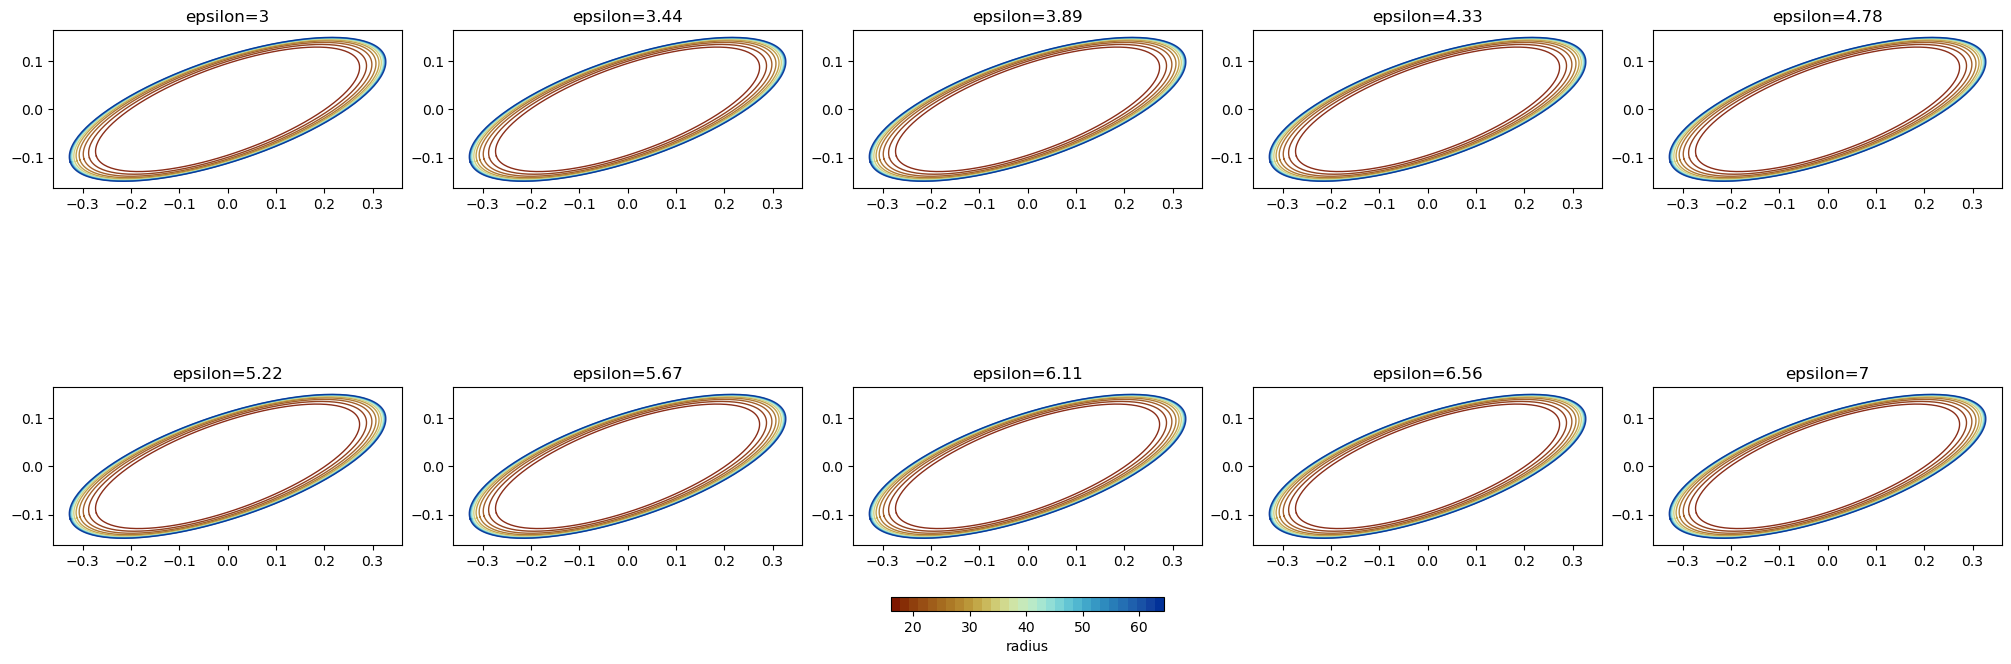

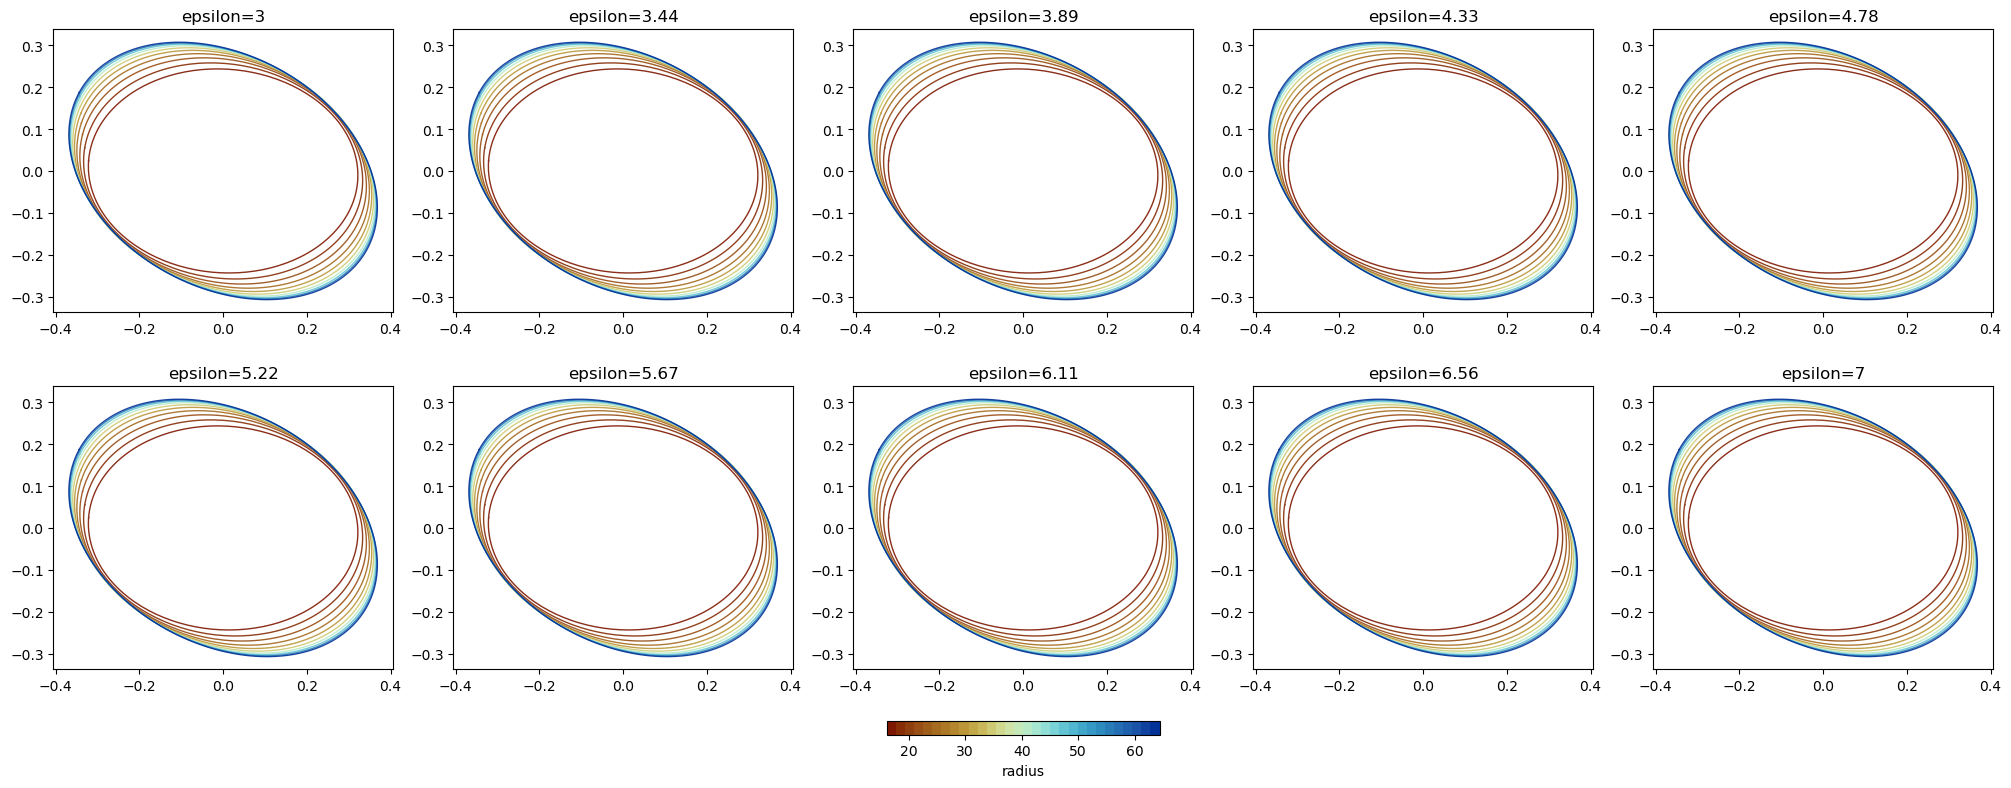

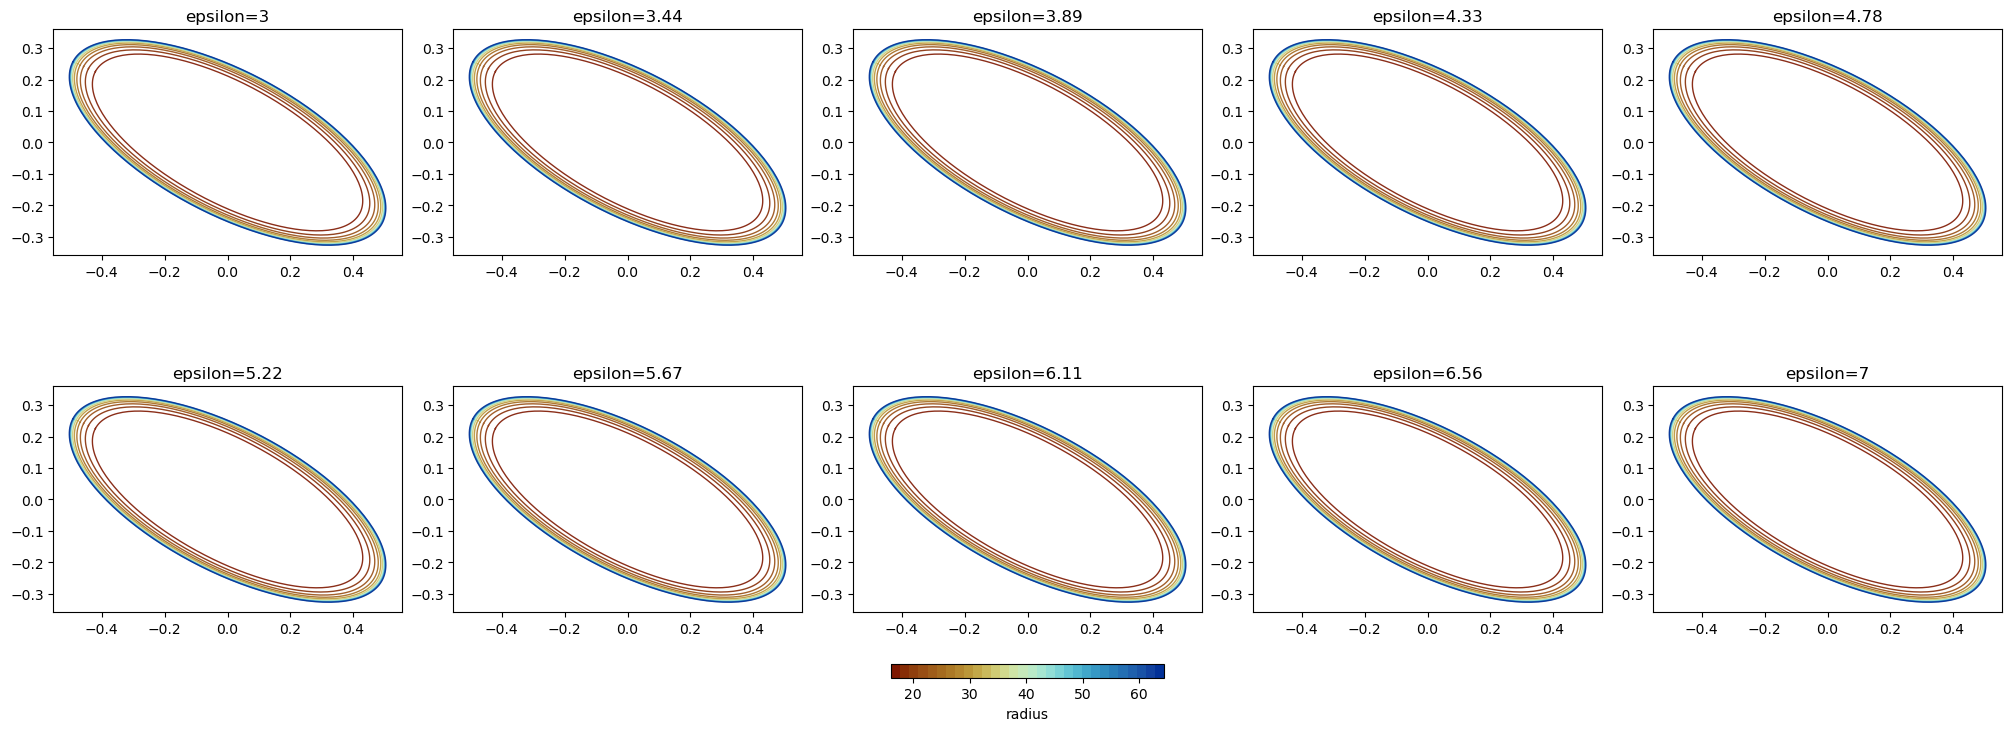

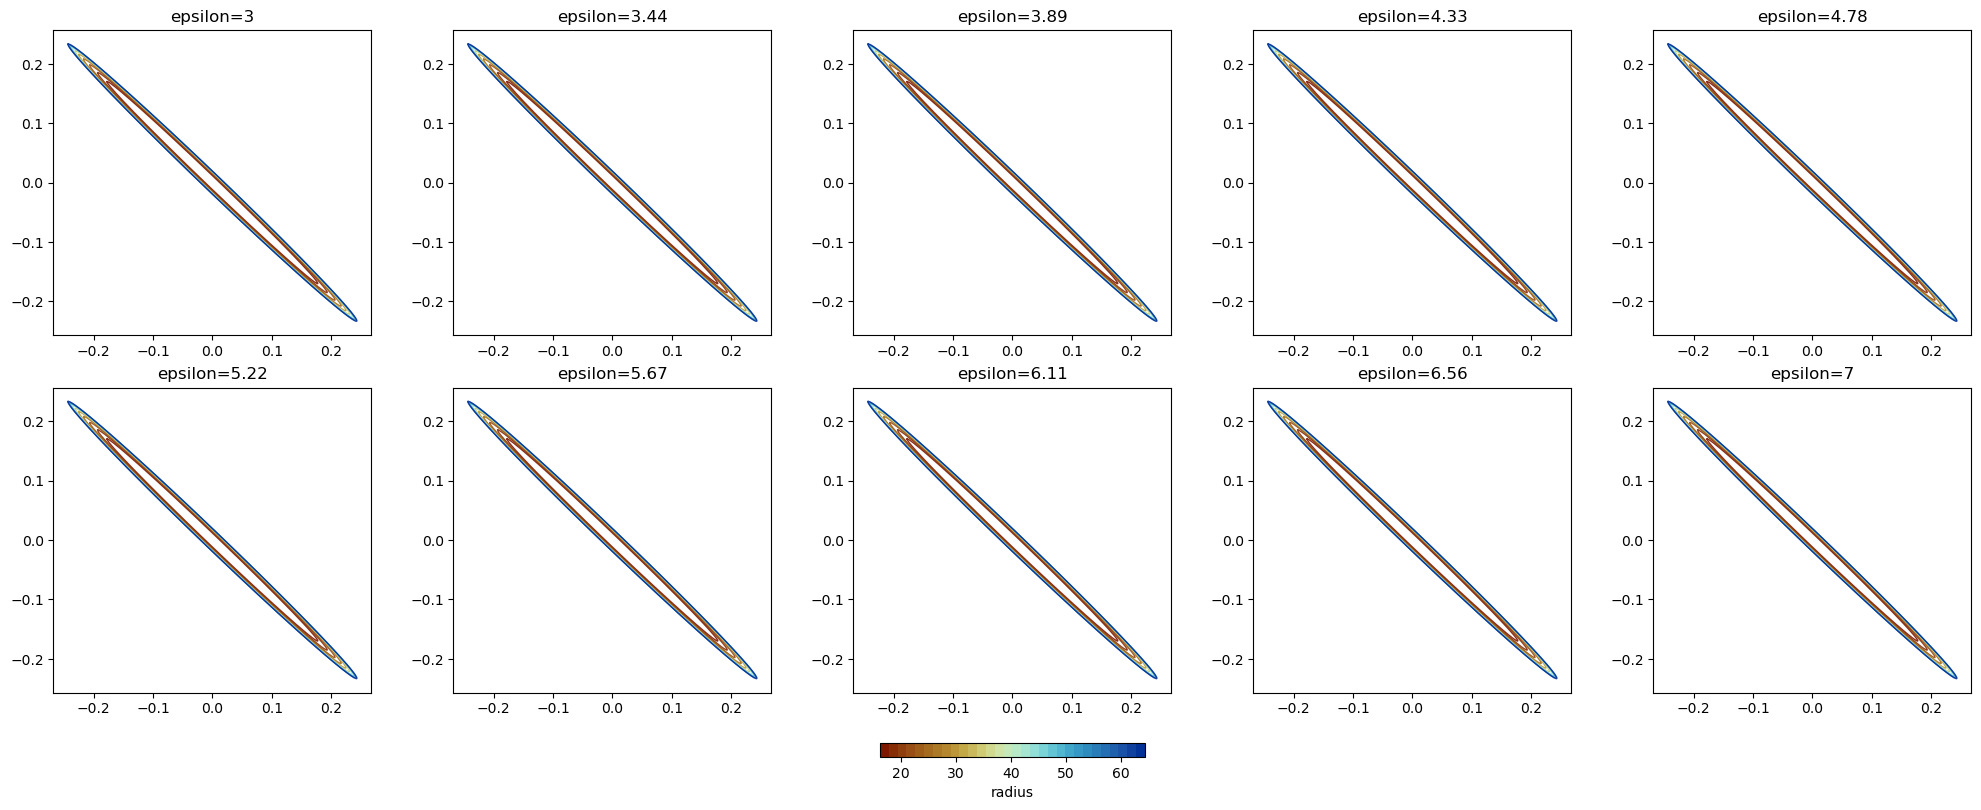

In [15]:
for i in random_samples:
    sample_df = plot_df[(plot_df["sample"] == i)]
    Hvv_i, Hs_i = ellipse_sequence(sample_df)
    plot_ellipses(Hvv_i, Hs_i, sample_df)

Almost all the singular vectors were stable -- but a few were not. What might be responsible for this? Let's pick a few examples and analyze in more depth.

In [16]:
sub_df

sample  combination      hv00      hv11      hv01      hv10       hs0  \
1100        11            0 -0.889882  0.889882  0.456191  0.456191  2.655257   
1101        11            1 -0.889882  0.889882  0.456191  0.456191  2.655257   
1102        11            2 -0.889882  0.889882  0.456191  0.456191  2.655257   
1103        11            3 -0.889882  0.889882  0.456191  0.456191  2.655257   
1104        11            4 -0.889882  0.889882  0.456191  0.456191  2.655257   
...        ...          ...       ...       ...       ...       ...       ...   
997095    9970           95 -0.484864  0.484864  0.874590  0.874590  0.054277   
997096    9970           96 -0.484864  0.484864  0.874590  0.874590  0.054277   
997097    9970           97 -0.484864  0.484864  0.874590  0.874590  0.054277   
997098    9970           98 -0.484864  0.484864  0.874590  0.874590  0.054277   
997099    9970           99 -0.484864  0.484864  0.874590  0.874590  0.054277   

             hs1     radius  scaling_epps  
1100    0.037078  16.097414      3.000000  
1101    0.037078  16.097414      3.444444  
1102    0.037078  16.097414      3.888889  
1103    0.037078  16.097414      4.333333  
1104    0.037078  16.097414      4.777778  
...          ...        ...           ...  
997095  0.049231  64.389656      5.222222  
997096  0.049231  64.389656      5.666667  
997097  0.049231  64.389656      6.111111  
997098  0.049231  64.389656      6.555556  
997099  0.049231  64.389656      7.000000  

[50000 rows x 10 columns]

In [17]:
def sample_adj_diffs(df, col='hv00', sort_by='radius'):
    # returns DataFrame of adjacent absolute diffs per row (aligned with the
    # later row in the pair)
    out = []
    for s, g in df.groupby('sample'):
        g_sorted = g.sort_values(sort_by).reset_index(drop=True)
        diffs = g_sorted[col].diff().abs()
        for i in range(1, len(g_sorted)):
            out.append({
                'sample': s,
                'abs_diff': float(diffs.iloc[i]),
                'radius_prev': float(g_sorted.loc[i-1, sort_by]),
                'radius_curr': float(g_sorted.loc[i, sort_by]),
                'hv00_prev': float(g_sorted.loc[i-1, col]),
                'hv00_curr': float(g_sorted.loc[i, col])
            })
    return pd.DataFrame(out)

# compute all adjacent diffs
thresh = 0.1
adj = sample_adj_diffs(plot_df, col='hv00', sort_by='radius')
adj = adj[adj['abs_diff'] >= thresh].sort_values('abs_diff', ascending=False)
adj

sample  abs_diff  radius_prev  radius_curr  hv00_prev  hv00_curr
27947      282  1.658717    21.905200    25.553052   0.668439  -0.990278
797751    8058  1.644829    16.097414    18.778101   0.644997  -0.999832
332580    3359  1.600961    25.553052    29.808377   0.635254  -0.965707
248608    2511  1.537157    18.778101    21.905200   0.648442  -0.888714
145658    1471  1.522120    21.905200    25.553052   0.660227  -0.861893
...        ...       ...          ...          ...        ...        ...
118413    1196  0.103036    16.097414    18.778101  -0.338080  -0.235044
245133    2476  0.102851    16.097414    18.778101  -0.794161  -0.897013
132887    1342  0.101218    21.905200    25.553052  -0.729922  -0.831140
148123    1496  0.100459    18.778101    21.905200  -0.686773  -0.787232
722640    7299  0.100093    25.553052    29.808377  -0.627275  -0.527182

[274 rows x 6 columns]

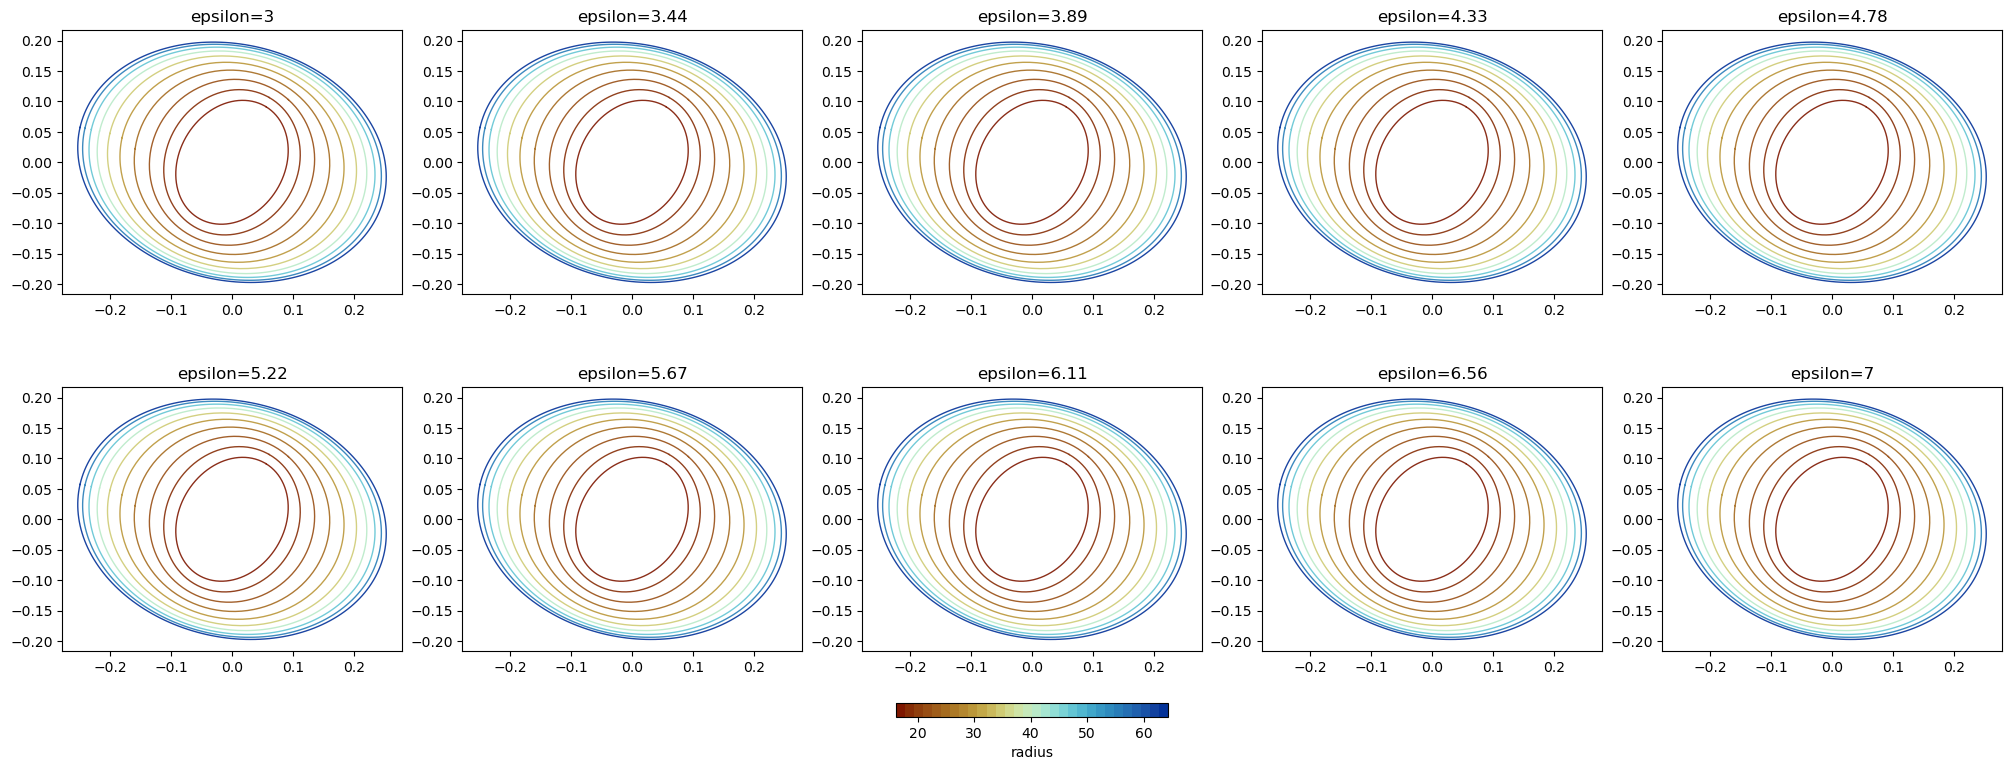

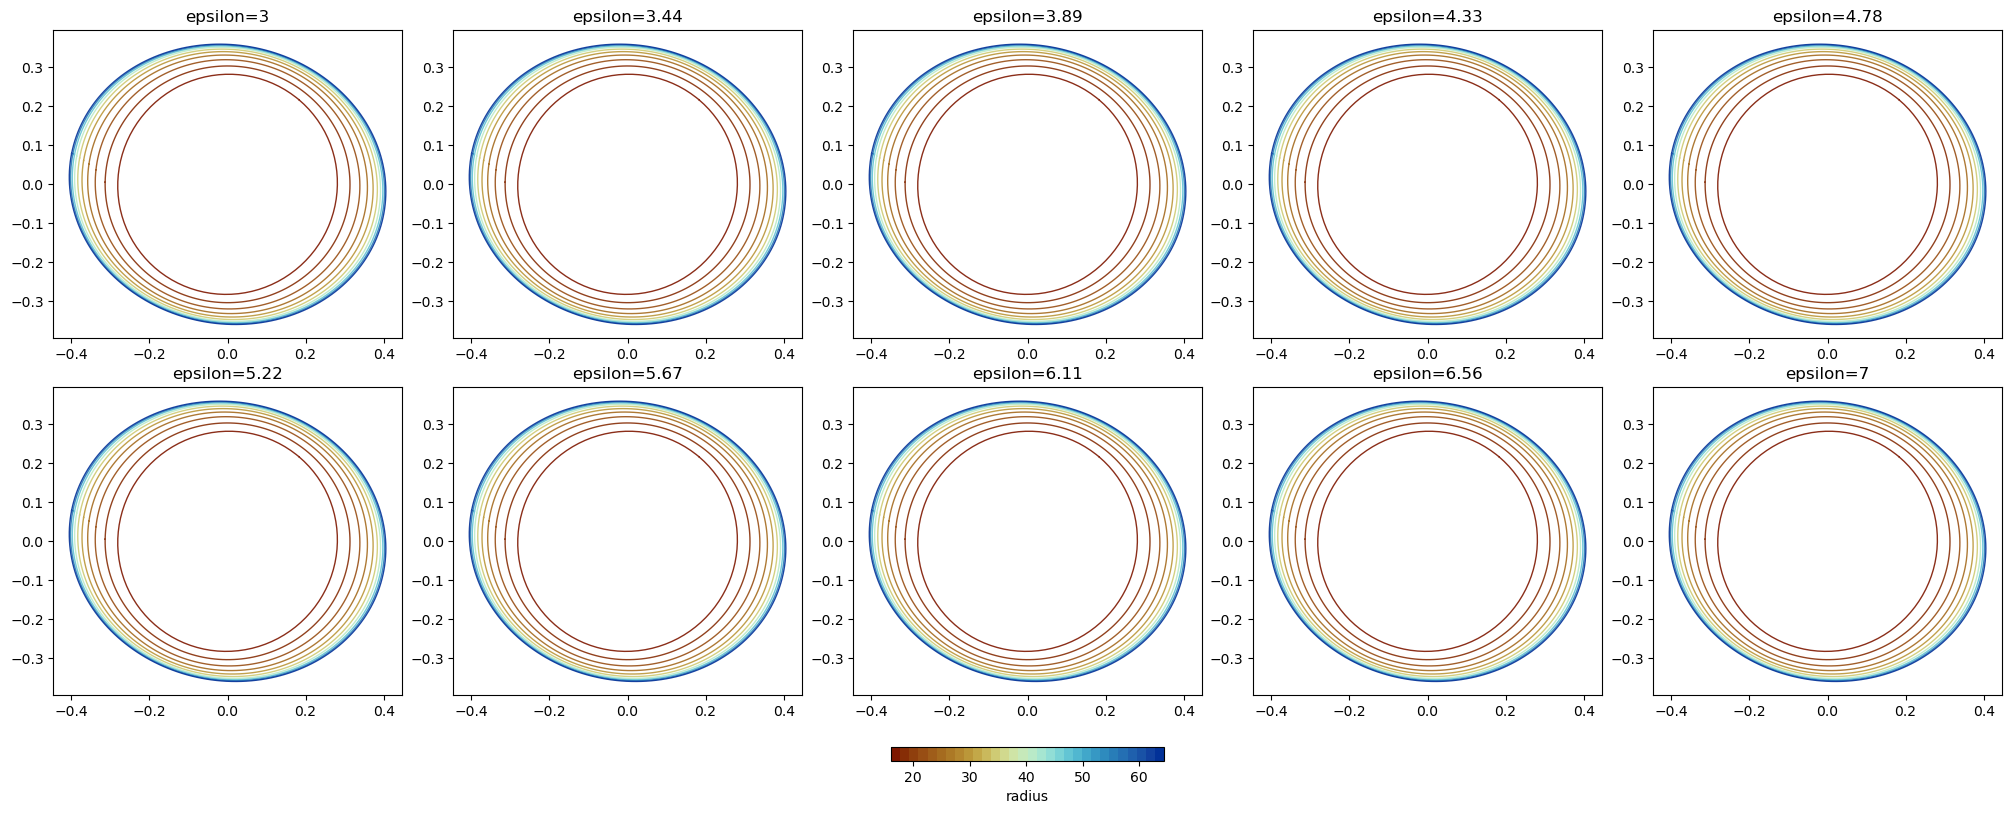

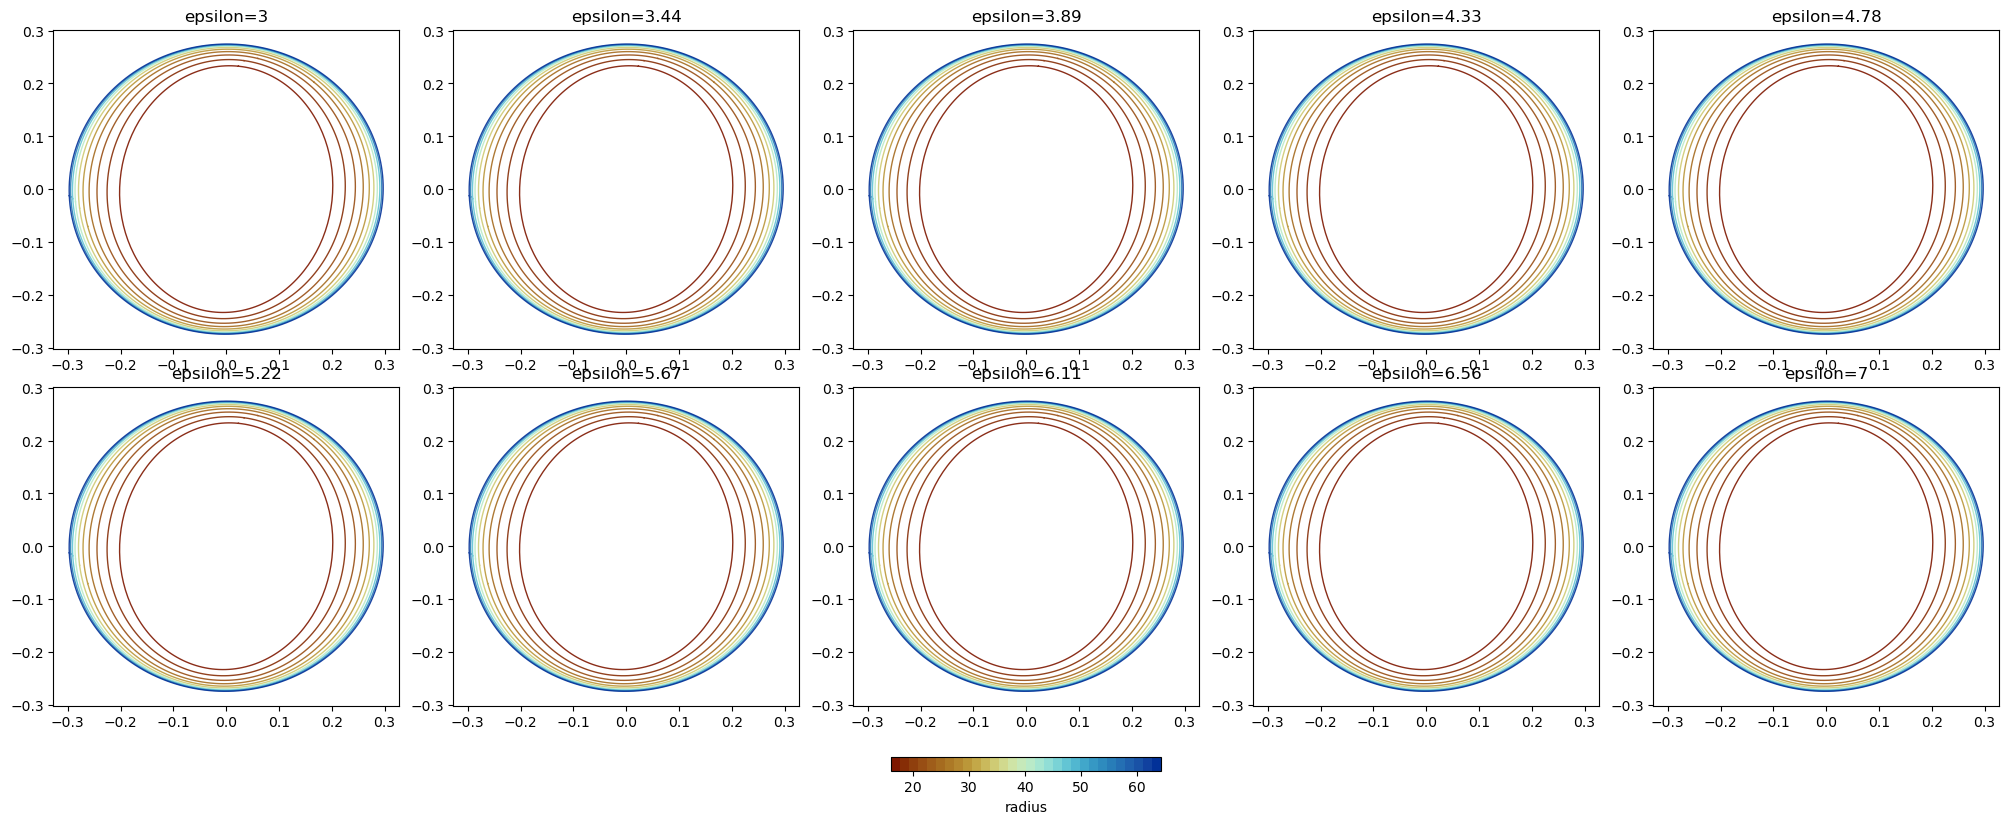

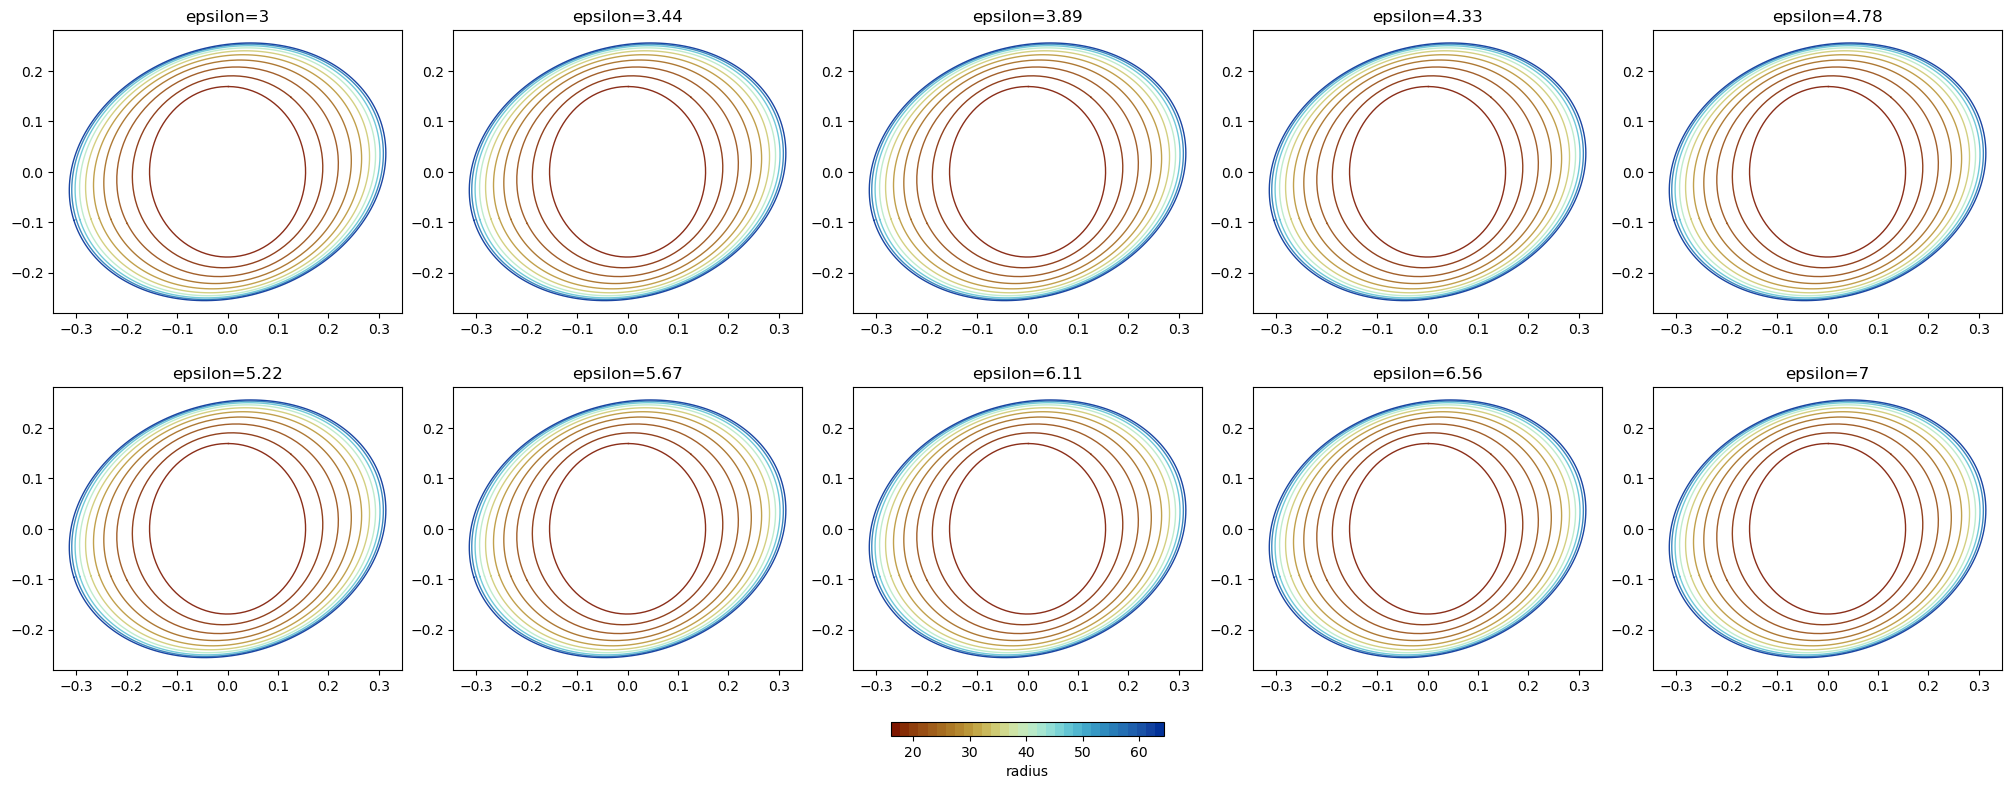

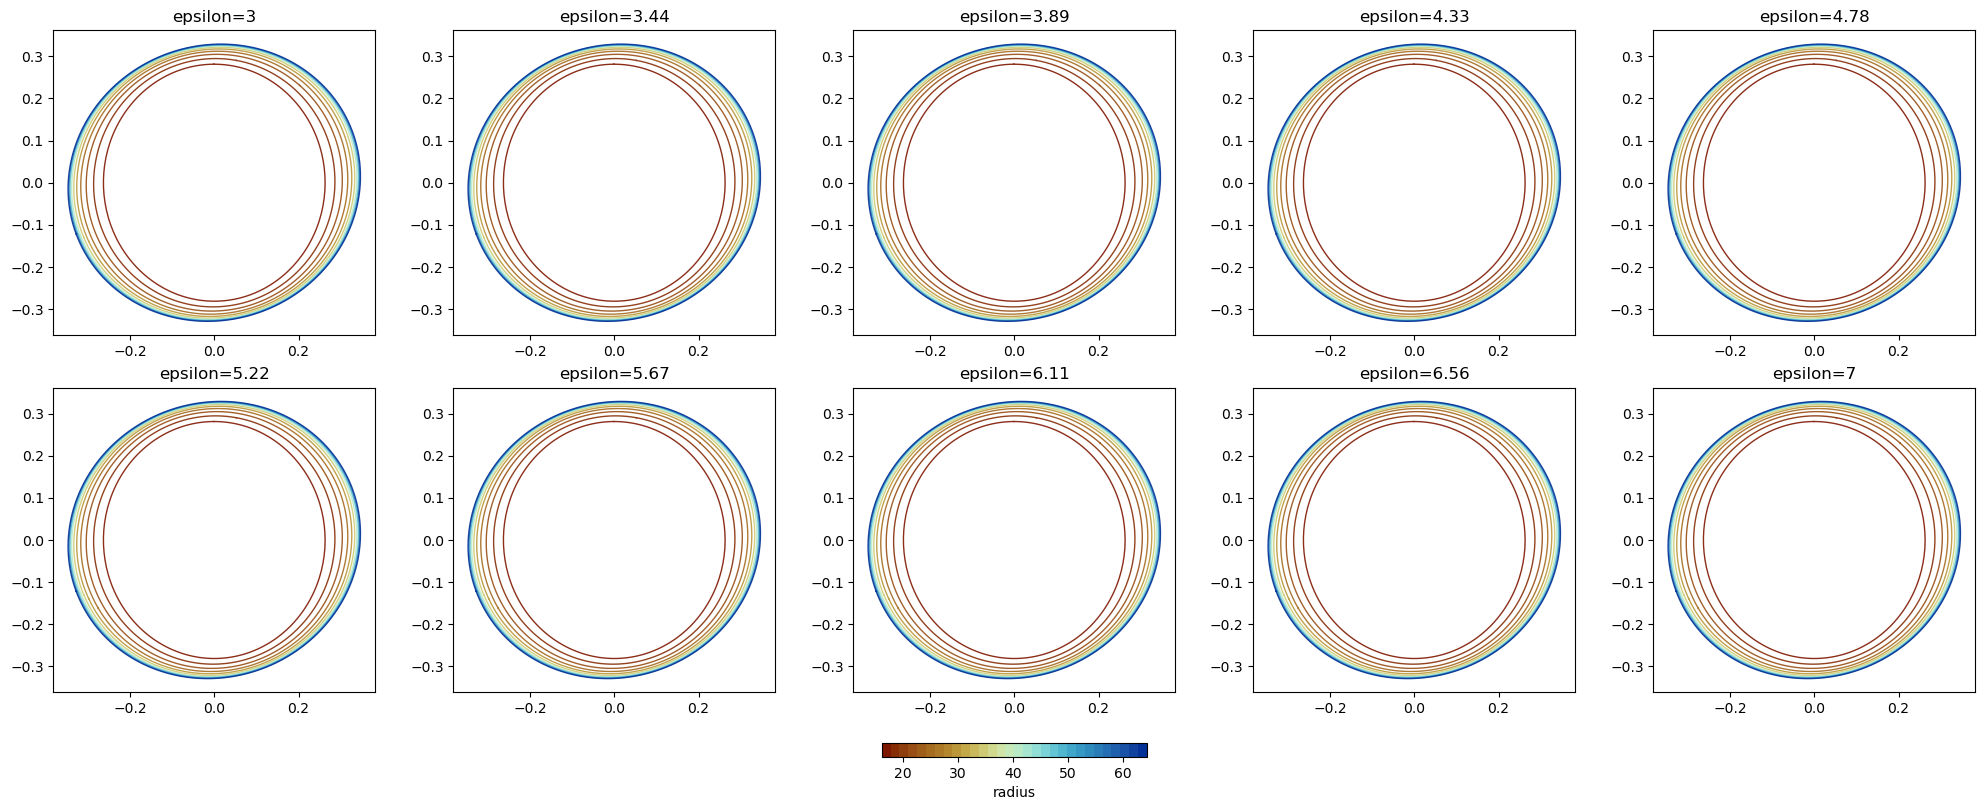

In [18]:
for i in adj["sample"].values[:5]:
    sample_df = plot_df[(plot_df["sample"] == i)]
    Hvv_i, Hs_i = ellipse_sequence(sample_df)
    plot_ellipses(Hvv_i, Hs_i, sample_df)

## Overlaying Ellipses

In [19]:
from distortions.geometry import bind_metric

embedding = adata.obsm["X_umap"].copy()
embedding_list = []

for i in range(len(Hvv)):
    embedding_i = bind_metric(embedding, Hvv[i], Hs[i])
    embedding_i["parameter_group"] = i
    embedding_i["sample"] = range(len(embedding_i))
    embedding_list.append(embedding_i)

In [20]:
combined_embedding = pd.concat(embedding_list)

ix = np.random.choice(embedding_list[0]["sample"], size=500, replace=False)
combined_embedding = combined_embedding[combined_embedding["sample"].isin(ix)]
combined_embedding = combined_embedding.merge(params_df, left_on="parameter_group", right_on="combination")
combined_embedding

embedding_0  embedding_1        x0        y0        x1        y1  \
0         7.375961    -0.011776 -0.983779 -0.179386 -0.179386  0.983779   
1         7.354166     8.815589 -0.871437  0.490507  0.490507  0.871437   
2        10.309316     4.898260 -0.983480  0.181017  0.181017  0.983480   
3        16.243284     6.437485 -0.831112 -0.556105 -0.556105  0.831112   
4        10.166615     4.376842  0.283942  0.958842  0.958842 -0.283942   
...            ...          ...       ...       ...       ...       ...   
49995    25.687422     9.248513 -0.868609  0.495498  0.495498  0.868609   
49996    21.379816    10.046772  0.438932  0.898520  0.898520 -0.438932   
49997    21.190882    10.283684 -0.830467 -0.557068 -0.557068  0.830467   
49998    21.102766    10.866966 -0.241780  0.970331  0.970331  0.241780   
49999    25.977240    10.568069 -0.963954  0.266068  0.266068  0.963954   

             s0        s1      angle  parameter_group  sample     radius  \
0      0.185832  0.067388 -79.665990                0       8  16.097414   
1      0.166502  0.057035  60.626081                0      16  16.097414   
2      0.226255  0.039947  79.570990                0      72  16.097414   
3      0.078166  0.008150 -56.213120                0     122  16.097414   
4      0.092243  0.047333 -16.495593                0     140  16.097414   
...         ...       ...        ...              ...     ...        ...   
49995  0.091448  0.045784  60.297414               99    9947  64.389656   
49996  0.062808  0.036358 -26.035779               99    9956  64.389656   
49997  0.095534  0.028097 -56.146751               99    9971  64.389656   
49998  0.066084  0.052895  13.991624               99    9975  64.389656   
49999  0.120325  0.034445  74.569565               99    9976  64.389656   

       scaling_epps  combination  
0               3.0            0  
1               3.0            0  
2               3.0            0  
3               3.0            0  
4               3.0            0  
...             ...          ...  
49995           7.0           99  
49996           7.0           99  
49997           7.0           99  
49998           7.0           99  
49999           7.0           99  

[50000 rows x 14 columns]

In [33]:
from distortions.visualization import dplot

pal = ["#CC533F", "#3C64D4"]
p = {}
p["subset_rcol"] = dplot(combined_embedding, height = 350, width=450)\
    .mapping(x="embedding_0", y="embedding_1", color="radius")\
    .geom_ellipse(opacity=0.1, radiusMin=1, radiusMax=20, stroke=True)\
    .scale_color(stroke=True, scheme=pal)\
    .labs(x="UMAP1", y="UMAP2")

In [34]:
p["subset_ecol"] = dplot(combined_embedding, height = 350, width=450)\
    .mapping(x="embedding_0", y="embedding_1", color="scaling_epps")\
    .geom_ellipse(opacity=0.1, radiusMin=1, radiusMax=20, stroke=True)\
    .scale_color(stroke=True)\
    .labs(x="UMAP1", y="UMAP2")

In [41]:
[v.save(f"{k}.svg") for (k, v) in p.items()]

[None, None]

In [40]:
[display(p_i) for p_i in p.values()]

dplot(dataset=[{'embedding_0': 7.375960826873779, 'embedding_1': -0.01177565474063158, 'x0': -0.98377873024196…

dplot(dataset=[{'embedding_0': 7.375960826873779, 'embedding_1': -0.01177565474063158, 'x0': -0.98377873024196…

[None, None]